In [1]:


save_dir = "/home/rhu/r_work/higher_semilearn/saved_models/cifar10"
save_name = "b_0.1_flexmatch_lossnet_cifar10_wrn_28_2_4000_lr0.03_True_bsz100_human_worst_0_False_1000_100_feat_expno1_uni_1e-05_beta0_2"
# save_pth = '/home/rhu/r_work/higher_semilearn/saved_log/cifar10/'+save_name
noise_ratio = 0.6
d_s=4000
b=100
# save_dir = "/home/rhu/r_work/higher_semilearn/saved_models/cifar10_uda"
# save_name = "flag_uda_cifar10_resnet18_1000_lr0.0005_False_bsz128_asy_0.6_True_8960_1280_None_zero_None_10"
# save_pth = '/home/rhu/r_work/higher_semilearn/saved_log/cifar10/'+save_name

# # resume = True
import warnings
warnings.filterwarnings("ignore")

iteration_l =list(range(0,30000,600))

In [2]:
import os
import matplotlib.pyplot as plt
import torch 
# import torch.nn as nn
# import IPython
from sklearn.metrics import recall_score,f1_score,precision_score, confusion_matrix,roc_auc_score,precision_recall_curve,auc
import numpy as np
from scipy.stats import gaussian_kde
# from utils import *
import torch.nn as nn
import torch.nn.functional as F
import re
import json
import collections
from itertools import islice, chain
from collections import OrderedDict, defaultdict
from typing import Optional, Callable, Tuple, Dict, Union
from torch.hub import load_state_dict_from_url

# from mlxtend.plotting import plot_decision_regions
from scipy.stats.kde import gaussian_kde
from numpy import linspace
# from torcheval.metrics import BinaryAUROC, BinaryF1Score, BinaryAUPRC


### Feature

In [3]:

path_dir=os.path.join(save_dir ,save_name)

weight_log = torch.load(os.path.join(path_dir,'data_weight_log.pt'))


from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import os

scalars =['train/sup_loss', 'train/sup_loss_true', 'train/unsup_loss', 'train/total_loss', 'train/mask_ratio', 'lr', 'train/prefecth_time', \
          'train/run_time', 'eval/loss', 'eval/top-1-acc', 'eval/balanced_acc', 'eval/precision', 'eval/recall', 'eval/F1', 'lid_logits', 'lid_feat',\
          'unl_ce_loss', 'tn_logits', 'fp_logits', 'fn_logits', 'tp_logits', 'tn_feat', 'fp_feat', 'fn_feat', 'tp_feat', 'tn_ce', 'fp_ce', 'fn_ce', 'tp_ce', \
          'f1_logits', 'f1_feat', 'f1_ce'] #'feat_std','cov_loss'

def parse_tensorboard(path_event, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path_event,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    scalars = ea.Tags()["scalars"]
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

event_name = os.listdir(os.path.join(path_dir,'tensorboard'))[-1]

path_event = os.path.join(path_dir,'tensorboard', event_name)

log_ = parse_tensorboard(path_event, scalars)
print(weight_log.keys(), '\n',log_.keys())

from utils import *
def clean_ratio_batch(log_,var_name):
    N = log_['lid_80/tn_{}'.format(var_name)]['value']+ log_['lid_80/fp_{}'.format(var_name)]['value']
    all_ = N + log_['lid_80/tp_{}'.format(var_name)]['value']+log_['lid_80/fn_{}'.format(var_name)]['value']
    return N/all_
def metric_smoothing(list_metrics,smoothing_alpha=0.9):
    
    s_list_metrics=[]
    p_l=0
    for i in range(len(list_metrics)):
        p_l = smoothing_alpha *p_l + (1 - smoothing_alpha)* list_metrics[i]
        s_list_metrics.append(p_l/(1 - smoothing_alpha**(i+1)))
    return s_list_metrics

smoothing_alpha =0.9
def smoothing_metrics(precision_logits, recall_logits,f1_logits):
    precision_logits_smooth=[]
    recall_logits_smooth=[]
    f1_logits_smooth=[]
    smoothing_alpha=0.9
    p_l=0
    r_l=0
    f_l=0

    for i in range(len(precision_logits)):
        p_l = smoothing_alpha *p_l + (1 - smoothing_alpha)* precision_logits[i]
        precision_logits_smooth.append(p_l/(1 - smoothing_alpha**(i+1)))

        r_l = smoothing_alpha *r_l + (1 - smoothing_alpha)* recall_logits[i]
        recall_logits_smooth.append(r_l/(1 - smoothing_alpha**(i+1)))
        f_l = smoothing_alpha *f_l + (1 - smoothing_alpha)* f1_logits[i]
        f1_logits_smooth.append(r_l/(1 - smoothing_alpha**(i+1)))
        
    return precision_logits_smooth, recall_logits_smooth, f1_logits_smooth


# def get_g_clean_noisy(weight_log,key):
#     noise_g_logits=[]

#     clean_g_logits=[]
    
#     for i,batch_idx in enumerate(weight_log['sample_idx']):
#         if weight_log[key][i].dim()==2:
#             for j,idx_ in enumerate(batch_idx) :
#                 if idx_.item() not in weight_log['clean_indices']:
#                     try:
#                         noise_g_logits.append(weight_log[key][i].squeeze()[j].item())
#                     except:
#                         print(weight_log[key][i].squeeze()[j],'\n --------------------',weight_log[key][i][j])
#             for j,idx_ in enumerate(batch_idx):
#                 if idx_.item() in weight_log['clean_indices']:
#                     try:
#                         clean_g_logits.append(weight_log[key][i].squeeze()[j].item())
#                     except:
#                         print(weight_log[key][i].squeeze()[j])

#         else:
#             noise_g_logits.append([weight_log[key][i][j].item() for j,idx_ in enumerate(batch_idx) if idx_.item() not in weight_log['clean_indices']])

#             clean_g_logits.append([weight_log[key][i][j].item() for j,idx_ in enumerate(batch_idx) if idx_.item() in weight_log['clean_indices'] ])
#     return noise_g_logits,clean_g_logits
def get_g_clean_noisy(weight_log,key):
    noise_g_logits=[]

    clean_g_logits=[]
    for i,batch_idx in enumerate(weight_log['sample_idx']):
        noise_g_logits.append([weight_log[key][i][j].item() for j,idx_ in enumerate(batch_idx) if idx_.item() not in weight_log['clean_indices']])

        clean_g_logits.append([weight_log[key][i][j].item() for j,idx_ in enumerate(batch_idx) if idx_.item() in weight_log['clean_indices'] ])
    
    return noise_g_logits,clean_g_logits


def get_weight_dict(weight_log,key_name):
    
    n_labelsample=4000
    clean_sample_dict = {k : [] for k in weight_log['clean_indices']}
    noisy_sample_dict = {k : [] for k in (set(range(n_labelsample))-set(weight_log['clean_indices']))}
    
    for i,batch_idx in enumerate(weight_log['sample_idx']):
        to_add=dict(zip([idx.item() for idx in batch_idx],[j.item() for j in weight_log[key_name][i]]))
        for key,val in to_add.items():
            if key in clean_sample_dict.keys():
                clean_sample_dict[key].append(val)
            if key in noisy_sample_dict.keys():
                noisy_sample_dict[key].append(val)  
            
    return noisy_sample_dict, clean_sample_dict 


def cal_metric(weight_log,key):
    precision=[]
    recall=[]
    f1=[]

    # noisy label=1, clean label=0
    for i in range(len(weight_log['iteration'])):
        pred = [1 if w<0 else 0 for w in weight_log[key][i].numpy() ]
        truth =[0 if idx_.item() in weight_log['clean_indices'] else 1 for idx_ in weight_log['sample_idx'][i]]
        r = recall_score(truth,pred,average='binary')
        p = precision_score(truth,pred,average='binary')
        f1_ = f1_score(truth,pred,average='binary')
        precision.append(p)
        recall.append(r)
        f1.append(f1_)
    precision_s, recall_s, f1_s = smoothing_metrics(precision, recall,f1)
    return precision, recall, f1, precision_s, recall_s, f1_s


    

# def cal_auc(weight_log,bottom_n):

#     auc_l =[]
#     auprc_l= []
#     bottom_percent =[]
#     top_percent =[]
#     for i in range(len(weight_log['iteration'])):
        
#         p = F.softmax(torch.clamp(weight_log['w_lid_feat_l2'][i],min=0),dim=-1)
#         # p = weight_log['w_lid_feat_l2'][i]
        
#         truth =[0 if idx_.item() in weight_log['clean_indices'] else 1 for idx_ in weight_log['sample_idx'][i]]
#         bottom_num_noisy = torch.tensor(truth)[torch.argsort(weight_log['w_lid_feat_l2'][i])[:bottom_n]]
        
#         bottem_ratio = bottom_num_noisy.sum()/sum(truth)
#         top_num_clean = 1- torch.tensor(truth)[torch.argsort(weight_log['w_lid_feat_l2'][i])[bottom_n:]]
#         top_clean_ratio = top_num_clean.sum()/(len(truth)-sum(truth))
        
#         precision, recall, thresholds = precision_recall_curve(truth, p)
#         auc_precision_recall = auc(recall, precision)
        
#         auc_l.append(roc_auc_score(truth,p))
#         auprc_l.append(auc_precision_recall)
#         bottom_percent.append(bottem_ratio.item())
#         top_percent.append(top_clean_ratio.item())
#     return auc_l , auprc_l, bottom_percent,top_percent

# bottom_n=30
# try:
#     auc_l , auprc_l,bottom_percent,top_percent = cal_auc(weight_log,bottom_n)
# except:
#     auc_l , auprc_l,bottom_percent,top_percent = None, None, None, None

def cal_auc(weight_log,bottom_n=30,top_n=70):

    auc_l =[]
    auprc_l= []
    bottom_percent =[]
    top_percent =[]
    for i in range(len(weight_log['iteration'])):
        
        p = F.softmax(torch.clamp(weight_log['w_lid_feat_l2'][i],min=0),dim=-1)
        # p = weight_log['w_lid_feat_l2'][i]
        
        truth =[0 if idx_.item() in weight_log['clean_indices'] else 1 for idx_ in weight_log['sample_idx'][i]]
        num_in=len(truth)
        bottom_n_i= int(num_in*bottom_n/100)
        top_n_i= int(num_in*top_n/100)

        
        bottom_num_noisy = torch.tensor(truth)[torch.argsort(weight_log['w_lid_feat_l2'][i])[:bottom_n_i]]
        
        # bottem_ratio = bottom_num_noisy.sum()/sum(truth)
        # top_num_clean = torch.tensor(truth)[torch.argsort(weight_log['w_lid_feat_l2'][i])[-top_n_i:]]
        # top_clean_ratio = top_num_clean.sum()/(len(truth)-sum(truth))
        bottom_ratio = bottom_num_noisy.sum()/sum(truth)
        top_num_noisy = torch.tensor(truth)[torch.argsort(weight_log['w_lid_feat_l2'][i])[-top_n_i:]]
        top_ratio = top_num_noisy.sum()/sum(truth)
        
        precision, recall, thresholds = precision_recall_curve(truth, p)
        auc_precision_recall = auc(recall, precision)
        
        auc_l.append(roc_auc_score(truth,p))
        auprc_l.append(auc_precision_recall)
        bottom_percent.append(bottom_ratio.item())
        top_percent.append(top_ratio.item())
    return auc_l , auprc_l, bottom_percent,top_percent




dict_keys(['true_label', 'train_labels', 'clean_indices', 'iteration', 'sample_idx', 'w_ce_loss', 'w_lid_logits_l2', 'w_lid_feat_l2', 'w_lid_logits_cos', 'w_lid_feat_cos', 'lid_feat_l2', 'lid_feat_cos', 'lid_logits_l2', 'lid_logits_cos', 'unl_ce_loss', 'labi_loss', 'labi_lid_logits_l2', 'labi_lid_feat_l2', 'labi_lid_logits_cos', 'labi_lid_feat_cos', 'feat_std', 'cov_loss', 'total_meta_loss', 'auc', 'f1', 'auprc']) 
 dict_keys(['lid_80/lid_feat_l2', 'lid_80/unl_ce_loss', 'train/acc_lb', 'train/acc_lb_true', 'train/sup_loss', 'train/sup_loss_weighted', 'train/sup_loss_true', 'train/sup_loss_true_weighted', 'train_val_acc', 'train/unsup_loss', 'train/total_loss', 'train/mask_ratio', 'lr', 'train/prefecth_time', 'train/run_time', 'eval/loss', 'eval/top-1-acc', 'eval/balanced_acc', 'eval/precision', 'eval/recall', 'eval/F1'])


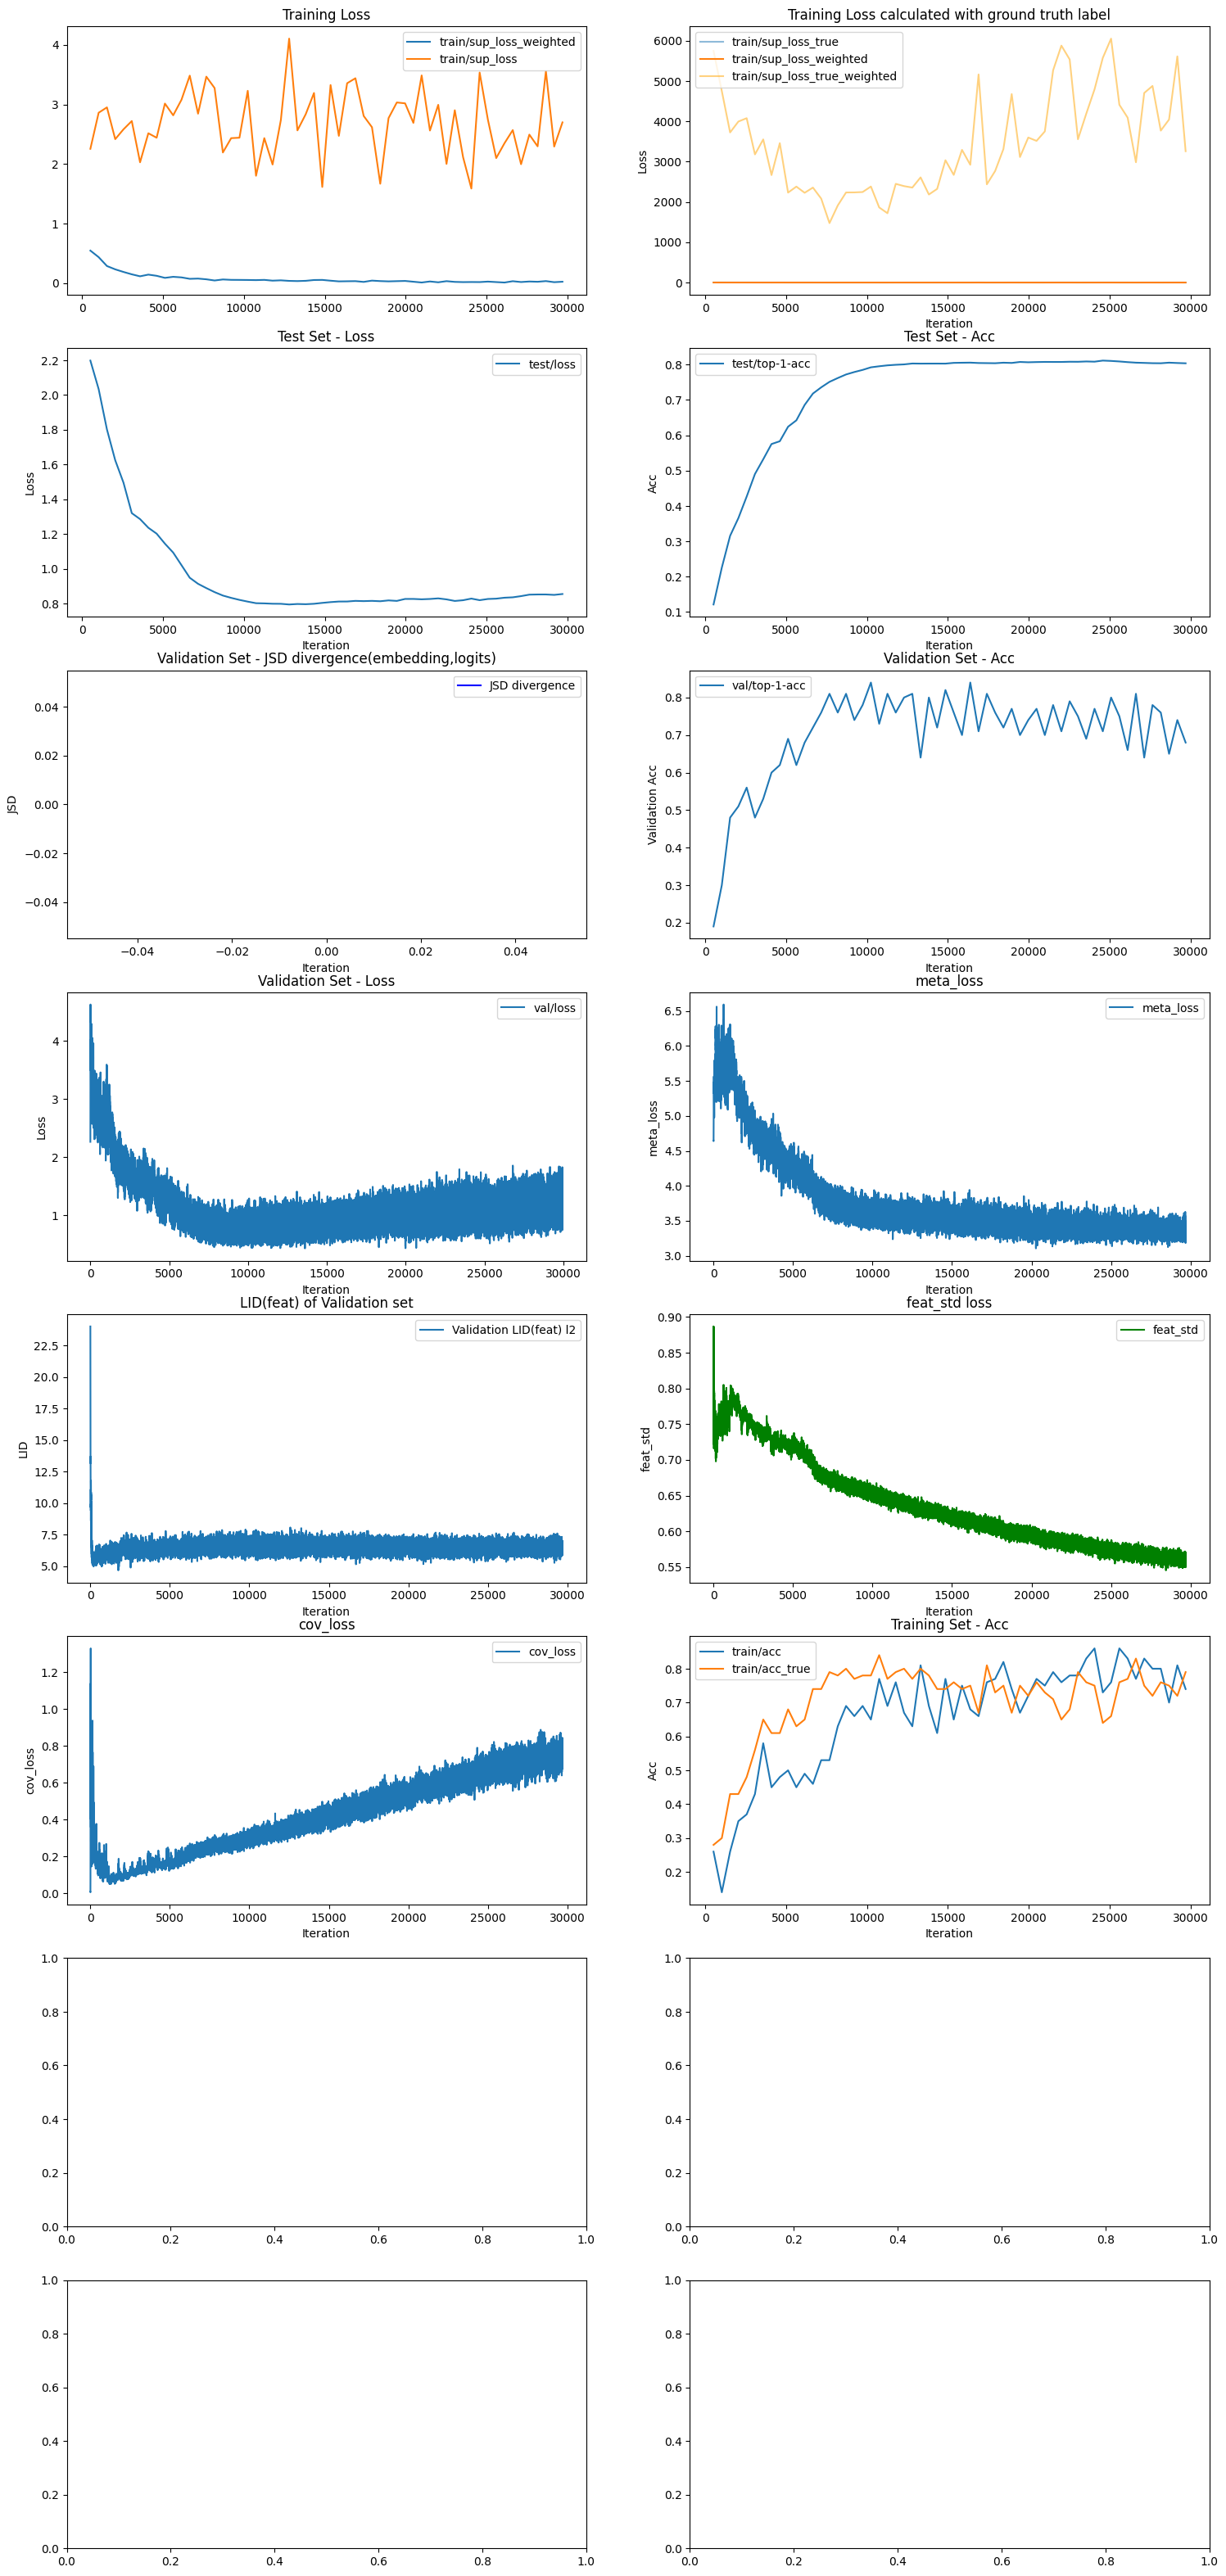

In [4]:

fig, axes = plt.subplots(8,2, figsize=(18,40))
ax1, ax2,ax3,ax4,ax5,ax6,ax7,ax8, ax9, ax10,ax11,ax12,ax13,ax14,ax15,ax16 = axes.ravel()

steps= len(log_['train/sup_loss']['step'])
s_l= log_['train/sup_loss']['step'][:steps]
# s_l=log_['train/sup_loss']['step']
ax1.plot(s_l, log_['train/sup_loss_weighted']['value'][:steps], label='train/sup_loss_weighted') #which is the training loss
ax1.plot(s_l, log_['train/sup_loss']['value'][:steps], label='train/sup_loss')
# ax1.plot(steps,log_['train/sup_loss_true']['value'], alpha=0.5,label='train/sup_loss_true')
# ax1.plot(steps,log_['train/sup_loss_true_weighted']['value'], alpha=0.5,c='orange',label='train/sup_loss_true_weighted')

# ax1.plot(steps, log_['train/sup_loss_true']['value'], label='train/sup_loss_true')
# ax1.plot(steps, log_['train/sup_loss_true_weighted']['value'], label='train/sup_loss_true_weighted')

# ax1.plot(s_l,log_['train/unsup_loss']['value'], label='train/unsup_loss')
# ax1.set_ylabel("Loss")
# ax1.set_xlabel("Iteration")
ax1.legend()
# ax1.set_ylim(0,0.28)
ax1.set_title('Training Loss')

# ax2=plt.subplot(5,2,2,sharey=ax1)
ax2.plot(s_l,log_['train/sup_loss_true']['value'][:steps], alpha=0.5,label='train/sup_loss_true')
ax2.plot(s_l, log_['train/sup_loss_weighted']['value'][:steps], label='train/sup_loss_weighted') #which is the training loss
ax2.plot(s_l,log_['train/sup_loss_true_weighted']['value'][:steps], alpha=0.5,c='orange',label='train/sup_loss_true_weighted')
ax2.set_ylabel("Loss")
# ax2.set_ylim(0,0.28)

ax2.set_xlabel("Iteration")
ax2.legend()
ax2.set_title('Training Loss calculated with ground truth label')



ax3.plot(log_['eval/loss']['step'],log_['eval/loss']['value'][:steps],label='test/loss')
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")
ax3.legend()
ax3.set_title('Test Set - Loss')

ax4.plot(log_['eval/top-1-acc']['step'],log_['eval/top-1-acc']['value'][:steps] ,label='test/top-1-acc')
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Acc")
ax4.legend()
ax4.set_title('Test Set - Acc')

ax5.plot(weight_log['f1'], c='blue', label='JSD divergence')
ax5.set_xlabel("Iteration")
ax5.set_ylabel("JSD")
ax5.legend()
ax5.set_title('Validation Set - JSD divergence(embedding,logits)')



ax6.plot(log_['train_val_acc']['step'][:steps],log_['train_val_acc']['value'][:steps],label='val/top-1-acc')
ax6.set_xlabel("Iteration")
ax6.set_ylabel("Validation Acc")
ax6.legend()
ax6.set_title('Validation Set - Acc')

ax7.plot(weight_log['unl_ce_loss'],label='val/loss')
ax7.set_xlabel("Iteration")
ax7.set_ylabel("Loss")
# ax7.set_ylim(0,0.28)

ax7.legend()
ax7.set_title("Validation Set - Loss")



# ax8.plot([i for i in weight_log['labi_lid_feat_l2']],label='LID(feat) l2')
# ax8.set_xlabel("Iteration")
# ax8.set_ylabel("LID")
# ax8.legend()
# ax8.set_title('Training Set - LID')

ax8.plot([i for i in weight_log['total_meta_loss']][:s_l[steps-1]],label='meta_loss')
ax8.set_xlabel("Iteration")
ax8.set_ylabel("meta_loss")
ax8.legend()
ax8.set_title('meta_loss')


ax9.plot(weight_log['lid_feat_l2'][:s_l[steps-1]] ,label='Validation LID(feat) l2')
ax9.set_xlabel("Iteration")
ax9.set_ylabel("LID")
ax9.legend()
ax9.set_title('LID(feat) of Validation set')




ax10.plot( weight_log['feat_std'][:s_l[steps-1]], c='green',label='feat_std') 
ax10.set_ylabel("feat_std")
ax10.set_xlabel("Iteration")
ax10.legend()
# ax1.set_ylim(0,0.28)
ax10.set_title('feat_std loss')

ax11.plot(weight_log['cov_loss'][:s_l[steps-1]], label='cov_loss') 
ax11.set_ylabel("cov_loss")
ax11.set_xlabel("Iteration")
ax11.legend()
ax11.set_title('cov_loss')


ax12.plot(log_['train/acc_lb']['step'][:steps],log_['train/acc_lb']['value'][:steps],label='train/acc')
ax12.plot(log_['train/acc_lb_true']['step'][:steps],log_['train/acc_lb_true']['value'][:steps],label='train/acc_true')
ax12.set_xlabel("Iteration")
ax12.set_ylabel("Acc")
ax12.legend()
ax12.set_title('Training Set - Acc')

# ax13.plot(weight_log['auc'], c='blue',label='H(z,p)')
# # ax13.plot(auc_l, c='blue',label='auc') 
# ax13.set_ylabel("H(z,p)")
# ax13.set_xlabel("Iteration")
# ax13.legend()
# ax13.set_title('cross entropuy(embedding,logits)')

# ax14.plot(weight_log['auprc'][:s_l[steps-1]], c='blue',label='H(p,z)') 
# ax14.set_ylabel("H(p,z)")
# ax14.set_xlabel("Iteration")
# ax14.legend()
# ax14.set_title('Cross entropy (logits,embedding)')

# try:
#     auc_l , auprc_l,bottom_percent,top_percent = cal_auc(weight_log,bottom_n=50,top_n=50)
# except:
#     auc_l , auprc_l,bottom_percent,top_percent = None, None, None, None
    
    
# ax15.plot(top_percent[:s_l[steps-1]], c='blue',label='top_percent') 
# ax15.set_ylabel("ratio")
# ax15.set_ylim(0,1)
# ax15.set_xlabel("Iteration")
# ax15.legend()
# ax15.set_title('noisy label identify ratio of top weights')

# ax16.plot(bottom_percent[:s_l[steps-1]], c='blue',label='bottom noisy rate') 
# ax16.set_ylabel("ratio")
# ax16.set_ylim(0,1)
# ax16.set_xlabel("Iteration")
# ax16.legend()
# ax16.set_title('noisy label identify ratio of bottom weights')
plt.show()

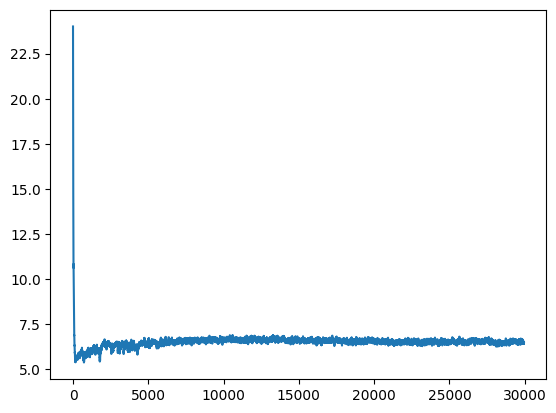

In [5]:
plt.plot(metric_smoothing(weight_log['lid_feat_l2']))

In [197]:
smoothed_lid=metric_smoothing(weight_log['lid_feat_l2'])
# smoothed_lid.index(min(smoothed_lid))
smoothed_lid.index(min(smoothed_lid))

667

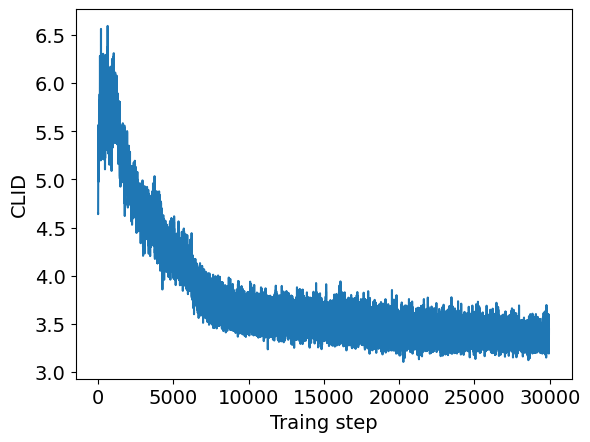

In [6]:
plt.plot(weight_log['total_meta_loss'])
plt.ylabel('CLID',fontsize=14)
plt.xlabel('Traing step',fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig(f'/home/rhu/r_work/higher_semilearn/figures/clid_loss_flex_random.pdf')


13414

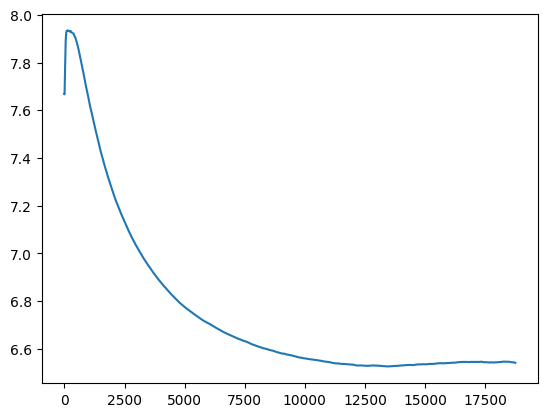

In [212]:
plt.plot(metric_smoothing(weight_log['total_meta_loss'],0.999))
smoothed_meat_loss=metric_smoothing(weight_log['total_meta_loss'],0.999)
smoothed_meat_loss.index(min(smoothed_meat_loss))

In [213]:
s_list_metrics = []
list_metrics = weight_log['total_meta_loss']
p_l=0

smoothing_alpha=0.999
for i in range(len(list_metrics)):
    p_l = smoothing_alpha *p_l + (1 - smoothing_alpha)* list_metrics[i]
    s_list_metrics.append(p_l/(1 - smoothing_alpha**(i+1)))
    diff=10000
    if i>2000:
        diff=np.mean(s_list_metrics[-5000:-1])-s_list_metrics[-1]
    if diff<0:
        print(i)
        break


15104


In [214]:
np.mean(s_list_metrics[-3000:-2])

6.530950312095622

In [215]:
np.mean(s_list_metrics[-1000:-1])

6.533997486453218

In [216]:
weight_log['true_label']

array([0, 0, 0, ..., 9, 9, 9])

In [7]:
weight_log['clean_indices']=np.where(weight_log['true_label'] == weight_log['train_labels'])[0]

### raw_weights

------------------------------------------------ lid_feat_l2


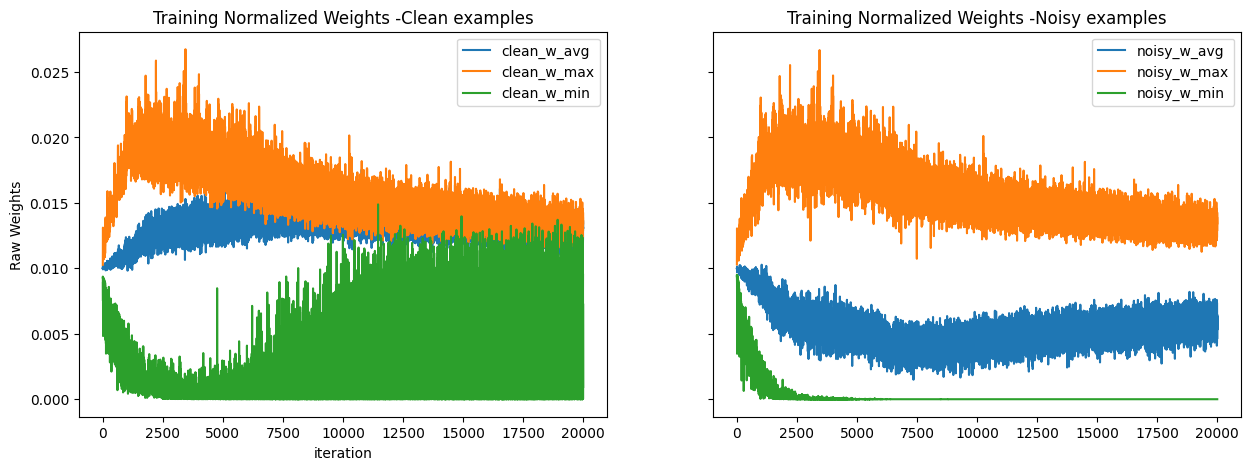

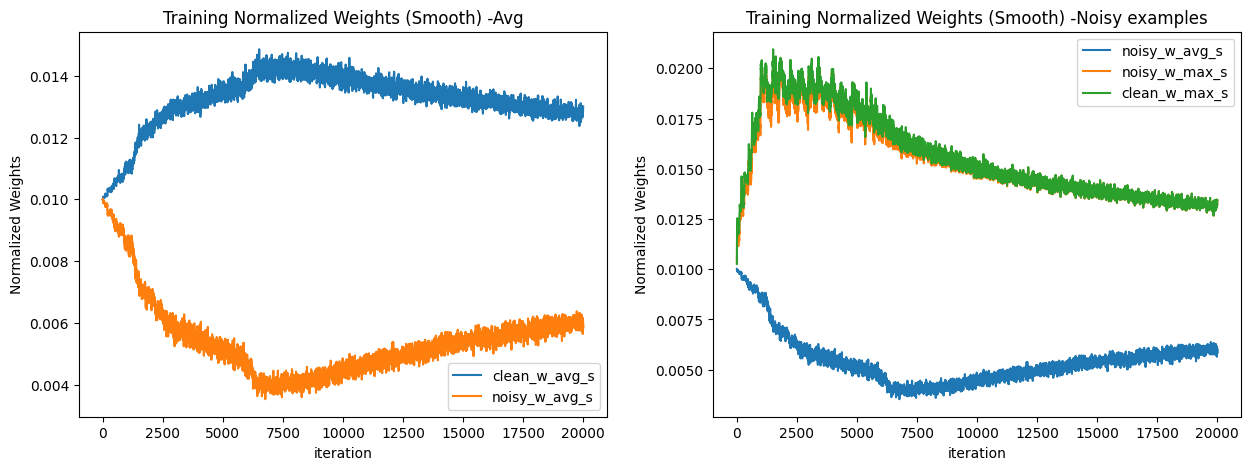

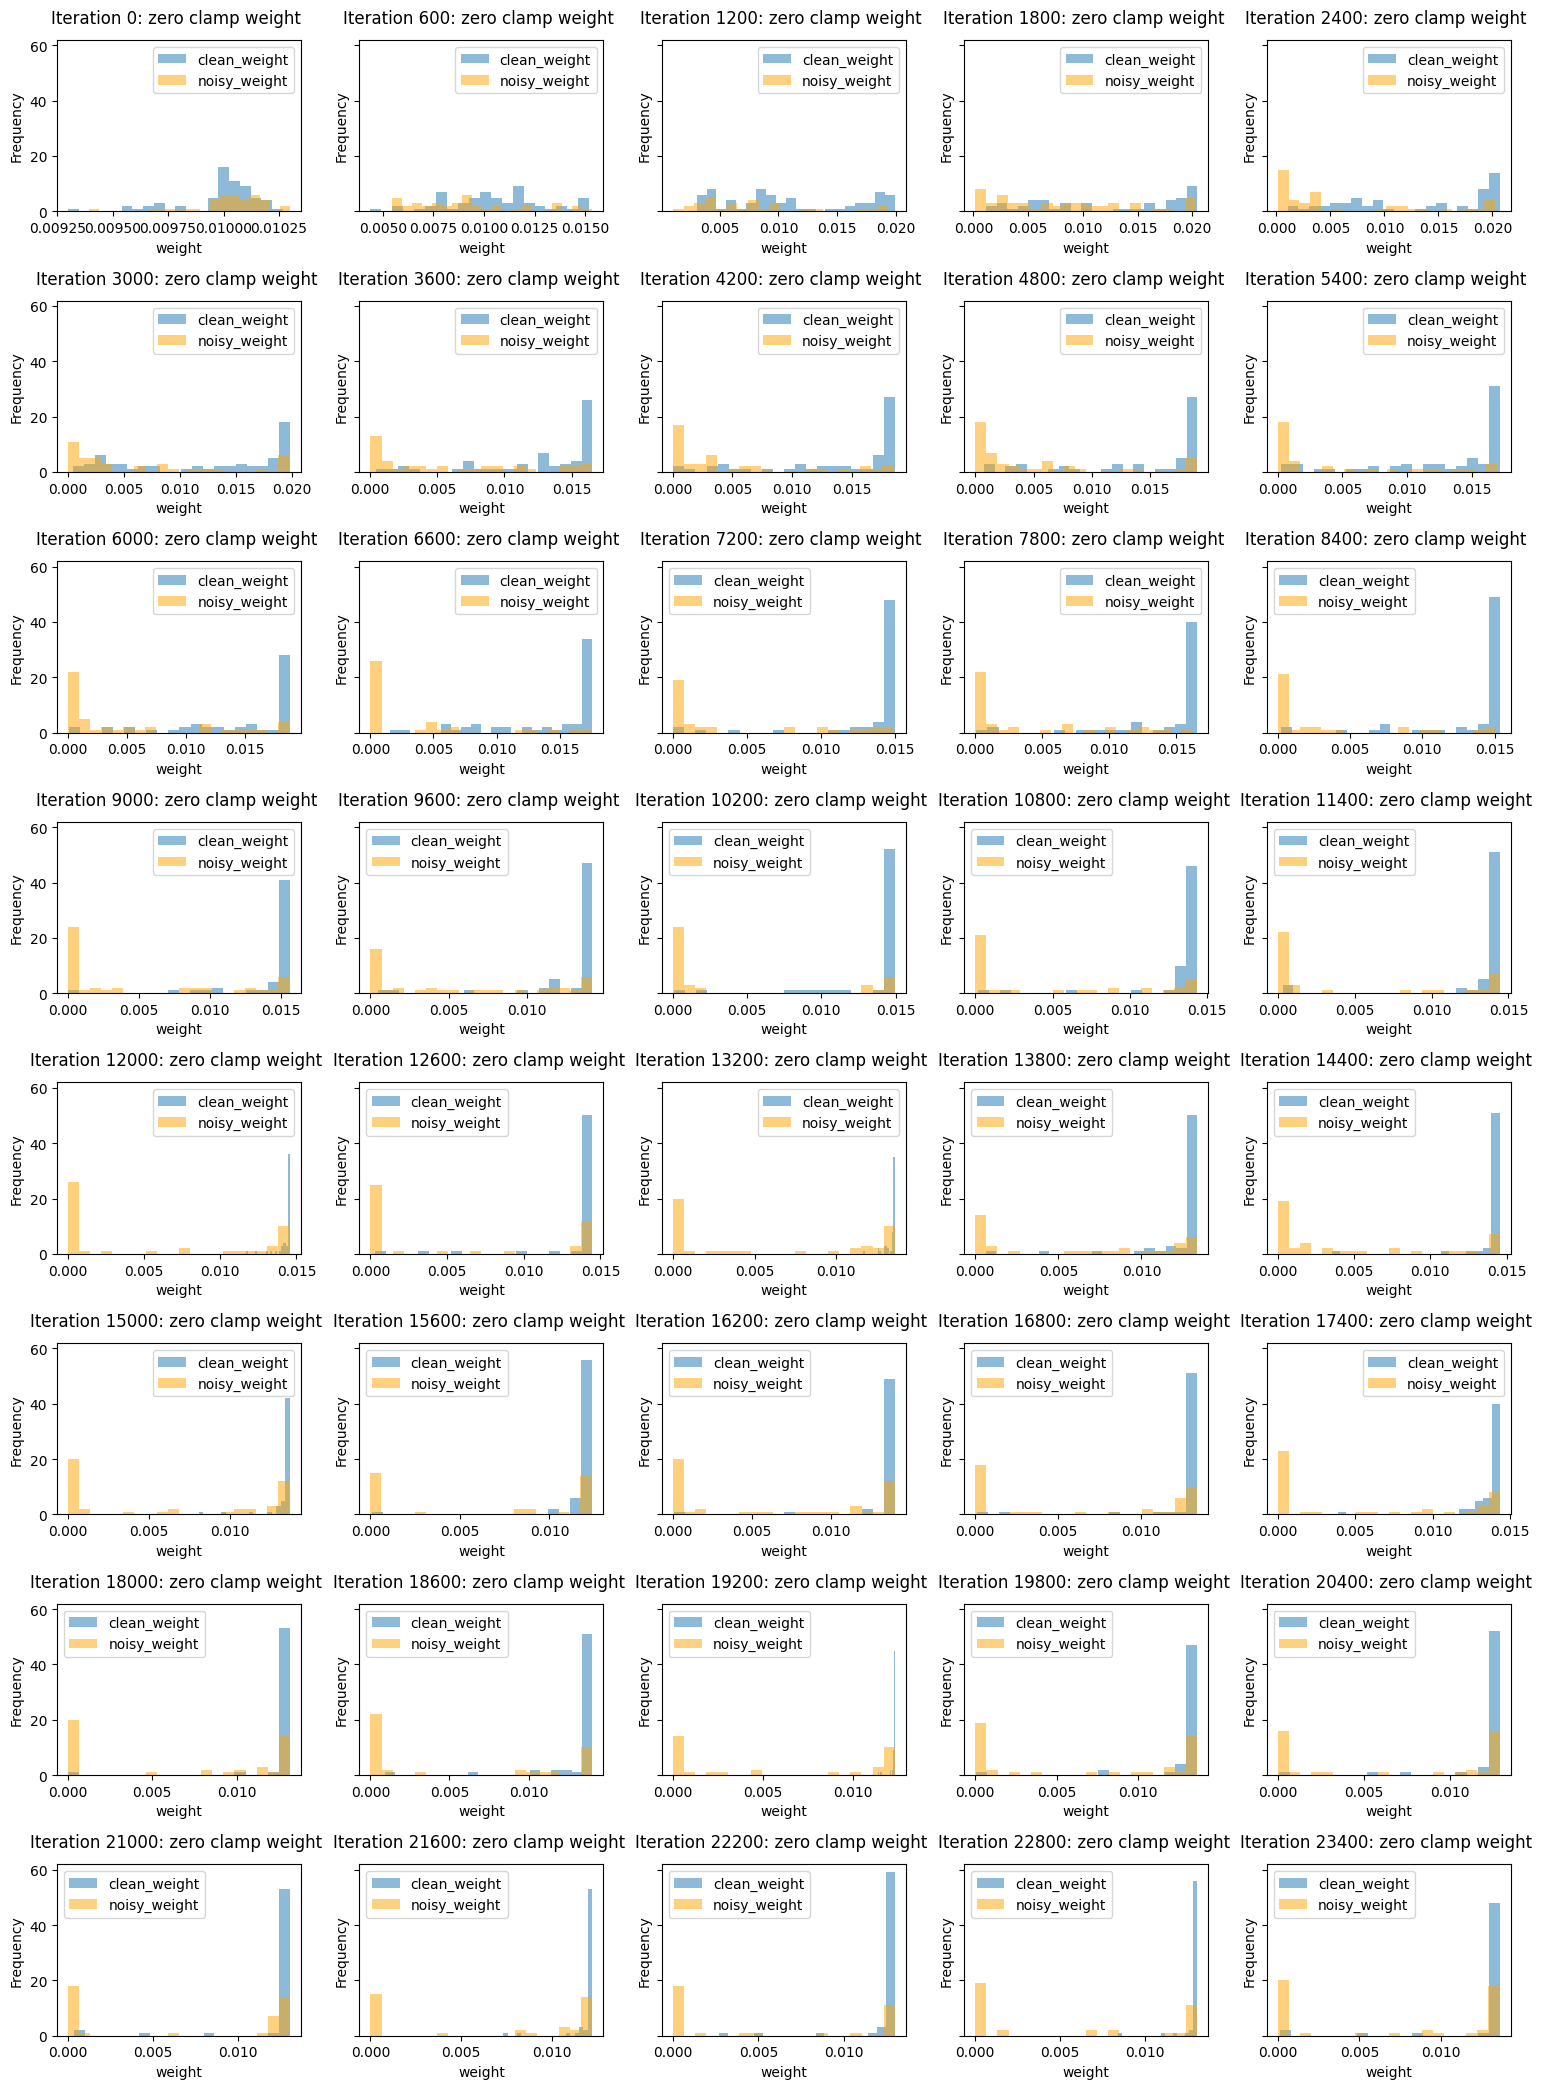

In [8]:
s=20000
for prefix in ['lid_feat_l2']:
    print('------------------------------------------------',prefix)
    w_noise_lid_logits, w_clean_lid_logits = get_g_clean_noisy(weight_log,'w_{}'.format(prefix))
    w_all = weight_log['w_{}'.format(prefix)]
    weight_log['w_lid_l2_nor'] =[]

    for it in range(len(w_all)):
        total_meta = torch.clamp(w_all[it], min=0)
        norm = torch.sum(total_meta)
        if norm!=0:
            total_meta /= torch.sum(total_meta)
        else:
            total_meta = torch.zeros(len(total_meta))
        weight_log['w_lid_l2_nor'].append(total_meta)
    w_noise_lid_logits_n, w_clean_lid_logits_n=get_g_clean_noisy(weight_log,'w_lid_l2_nor')

    noise_w_avg = [np.array(i).mean() for i in w_noise_lid_logits_n]
    noise_w_min = [np.array(i).min() for i in w_noise_lid_logits_n]
    noise_w_max = [np.array(i).max() for i in w_noise_lid_logits_n]

    clean_w_avg = [np.array(i).mean() for i in w_clean_lid_logits_n]
    clean_w_max = [np.array(i).max() for i in w_clean_lid_logits_n]
    clean_w_min = [np.array(i).min() for i in w_clean_lid_logits_n]

    # s=len(clean_w_avg)
    fig, axes = plt.subplots(1,2, figsize=(15,5),sharey=True)
    ax1, ax2 = axes.ravel()

    ax1.plot(clean_w_avg[:s],label='clean_w_avg')
    ax1.plot(clean_w_max[:s],label='clean_w_max')
    ax1.plot(clean_w_min[:s],label='clean_w_min')

    ax1.legend()
    ax1.set_title('Training Normalized Weights -Clean examples')
    ax1.set_ylabel('Raw Weights')
    ax1.set_xlabel('iteration')

    ax2.plot(noise_w_avg[:s],label='noisy_w_avg')
    ax2.plot(noise_w_max[:s],label='noisy_w_max')
    ax2.plot(noise_w_min[:s],label='noisy_w_min')
    ax2.legend()
    ax2.set_title('Training Normalized Weights -Noisy examples')
    ax1.set_ylabel('Raw Weights')
    ax1.set_xlabel('iteration')

    plt.show()


    clean_w_avg_s = metric_smoothing(clean_w_avg)
    clean_w_max_s =metric_smoothing(clean_w_max)

    noise_w_avg_s = metric_smoothing(noise_w_avg)
    noise_w_max_s = metric_smoothing(noise_w_max)




    fig, axes = plt.subplots(1,2, figsize=(15,5),sharey=False)
    ax1, ax2= axes.ravel()




    ax1.plot(clean_w_avg_s[:s],label='clean_w_avg_s')
    # ax3.plot(clean_w_max_s[:s],label='clean_w_max_s')
    ax1.plot(noise_w_avg_s[:s],label='noisy_w_avg_s')

    # ax1.plot(clean_w_min,label='clean_w_min')

    ax1.legend()
    ax1.set_title('Training Normalized Weights (Smooth) -Avg')
    ax1.set_ylabel('Normalized Weights')
    ax1.set_xlabel('iteration')

    ax2.plot(noise_w_avg_s[:s],label='noisy_w_avg_s')
    ax2.plot(noise_w_max_s[:s],label='noisy_w_max_s')
    ax2.plot(clean_w_max_s[:s],label='clean_w_max_s')
    # ax2.plot(noise_w_min,label='noisy_w_min')
    ax2.legend()
    ax2.set_title('Training Normalized Weights (Smooth) -Noisy examples')
    ax2.set_ylabel('Normalized Weights')
    ax2.set_xlabel('iteration')
    
    

    plt.show()
    plt.close()
    

    # iteration_l =list(range(0,100*int(it_perepo),max(s_,1)))
    # iteration_l =list(range(0,500,50))

    # iteration_l=list(range(40,50))
    fig, axes = plt.subplots(8, 5, tight_layout=True,sharey=True,figsize=(15.5,21))
    n_bins=20
    j=0
    for row in axes:
        for col in row:
            i = iteration_l[j]


            col.hist(w_clean_lid_logits_n[i], bins=n_bins, alpha =0.5,label ='clean_weight')
            col.hist(w_noise_lid_logits_n[i], bins=n_bins,alpha =0.5,label ='noisy_weight',color='orange')
            col.set_xlabel("weight")
            col.set_ylabel("Frequency")
            col.set_title('Iteration %i: zero clamp weight '%(i),y=1.05 )

            col.legend(loc='best')
            j+=1
            if j==len(iteration_l):
                break
        if j==len(iteration_l):
            break 

    
    plt.show()
    
    plt.close()
    
 



------------------------------------------------ lid_feat_l2


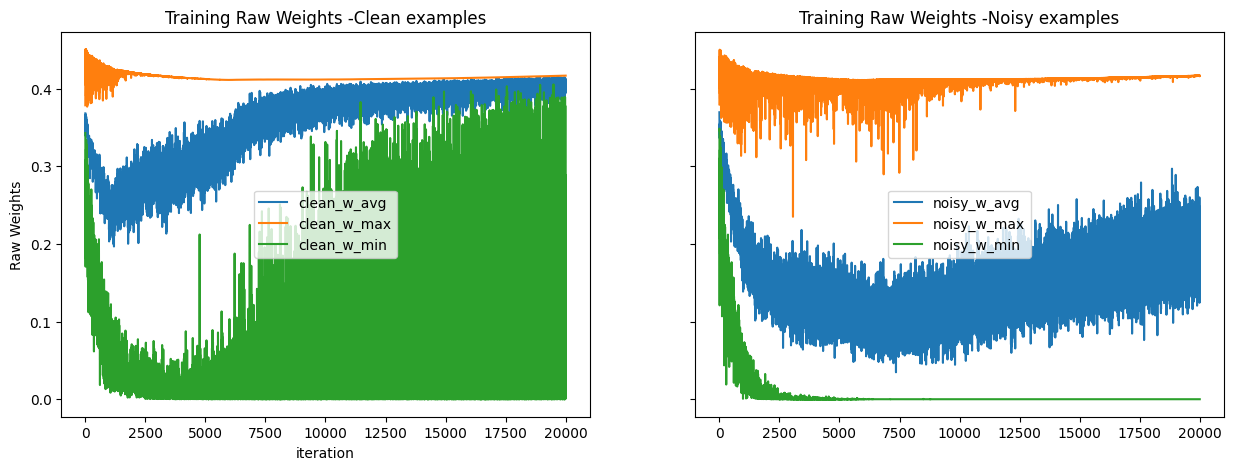

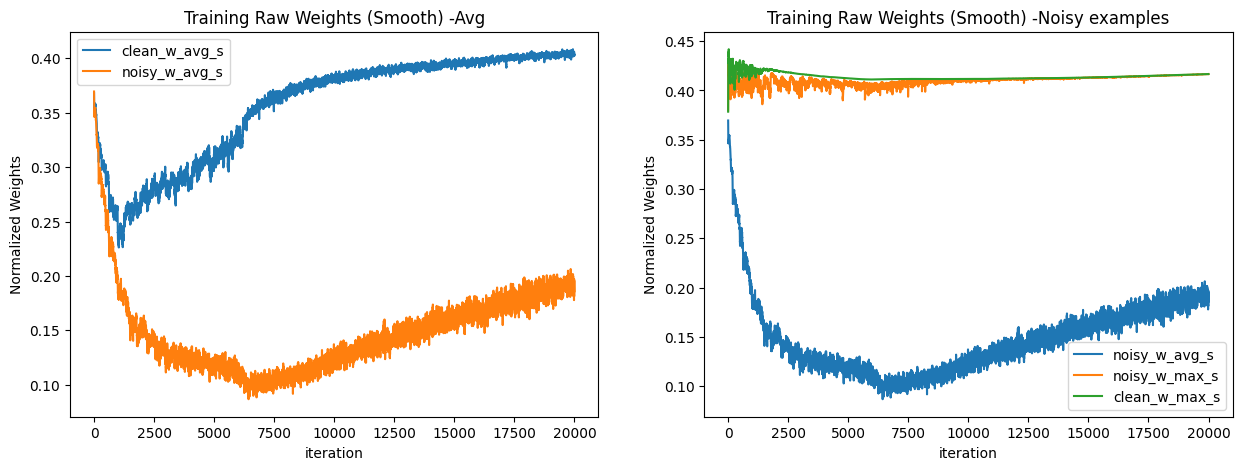

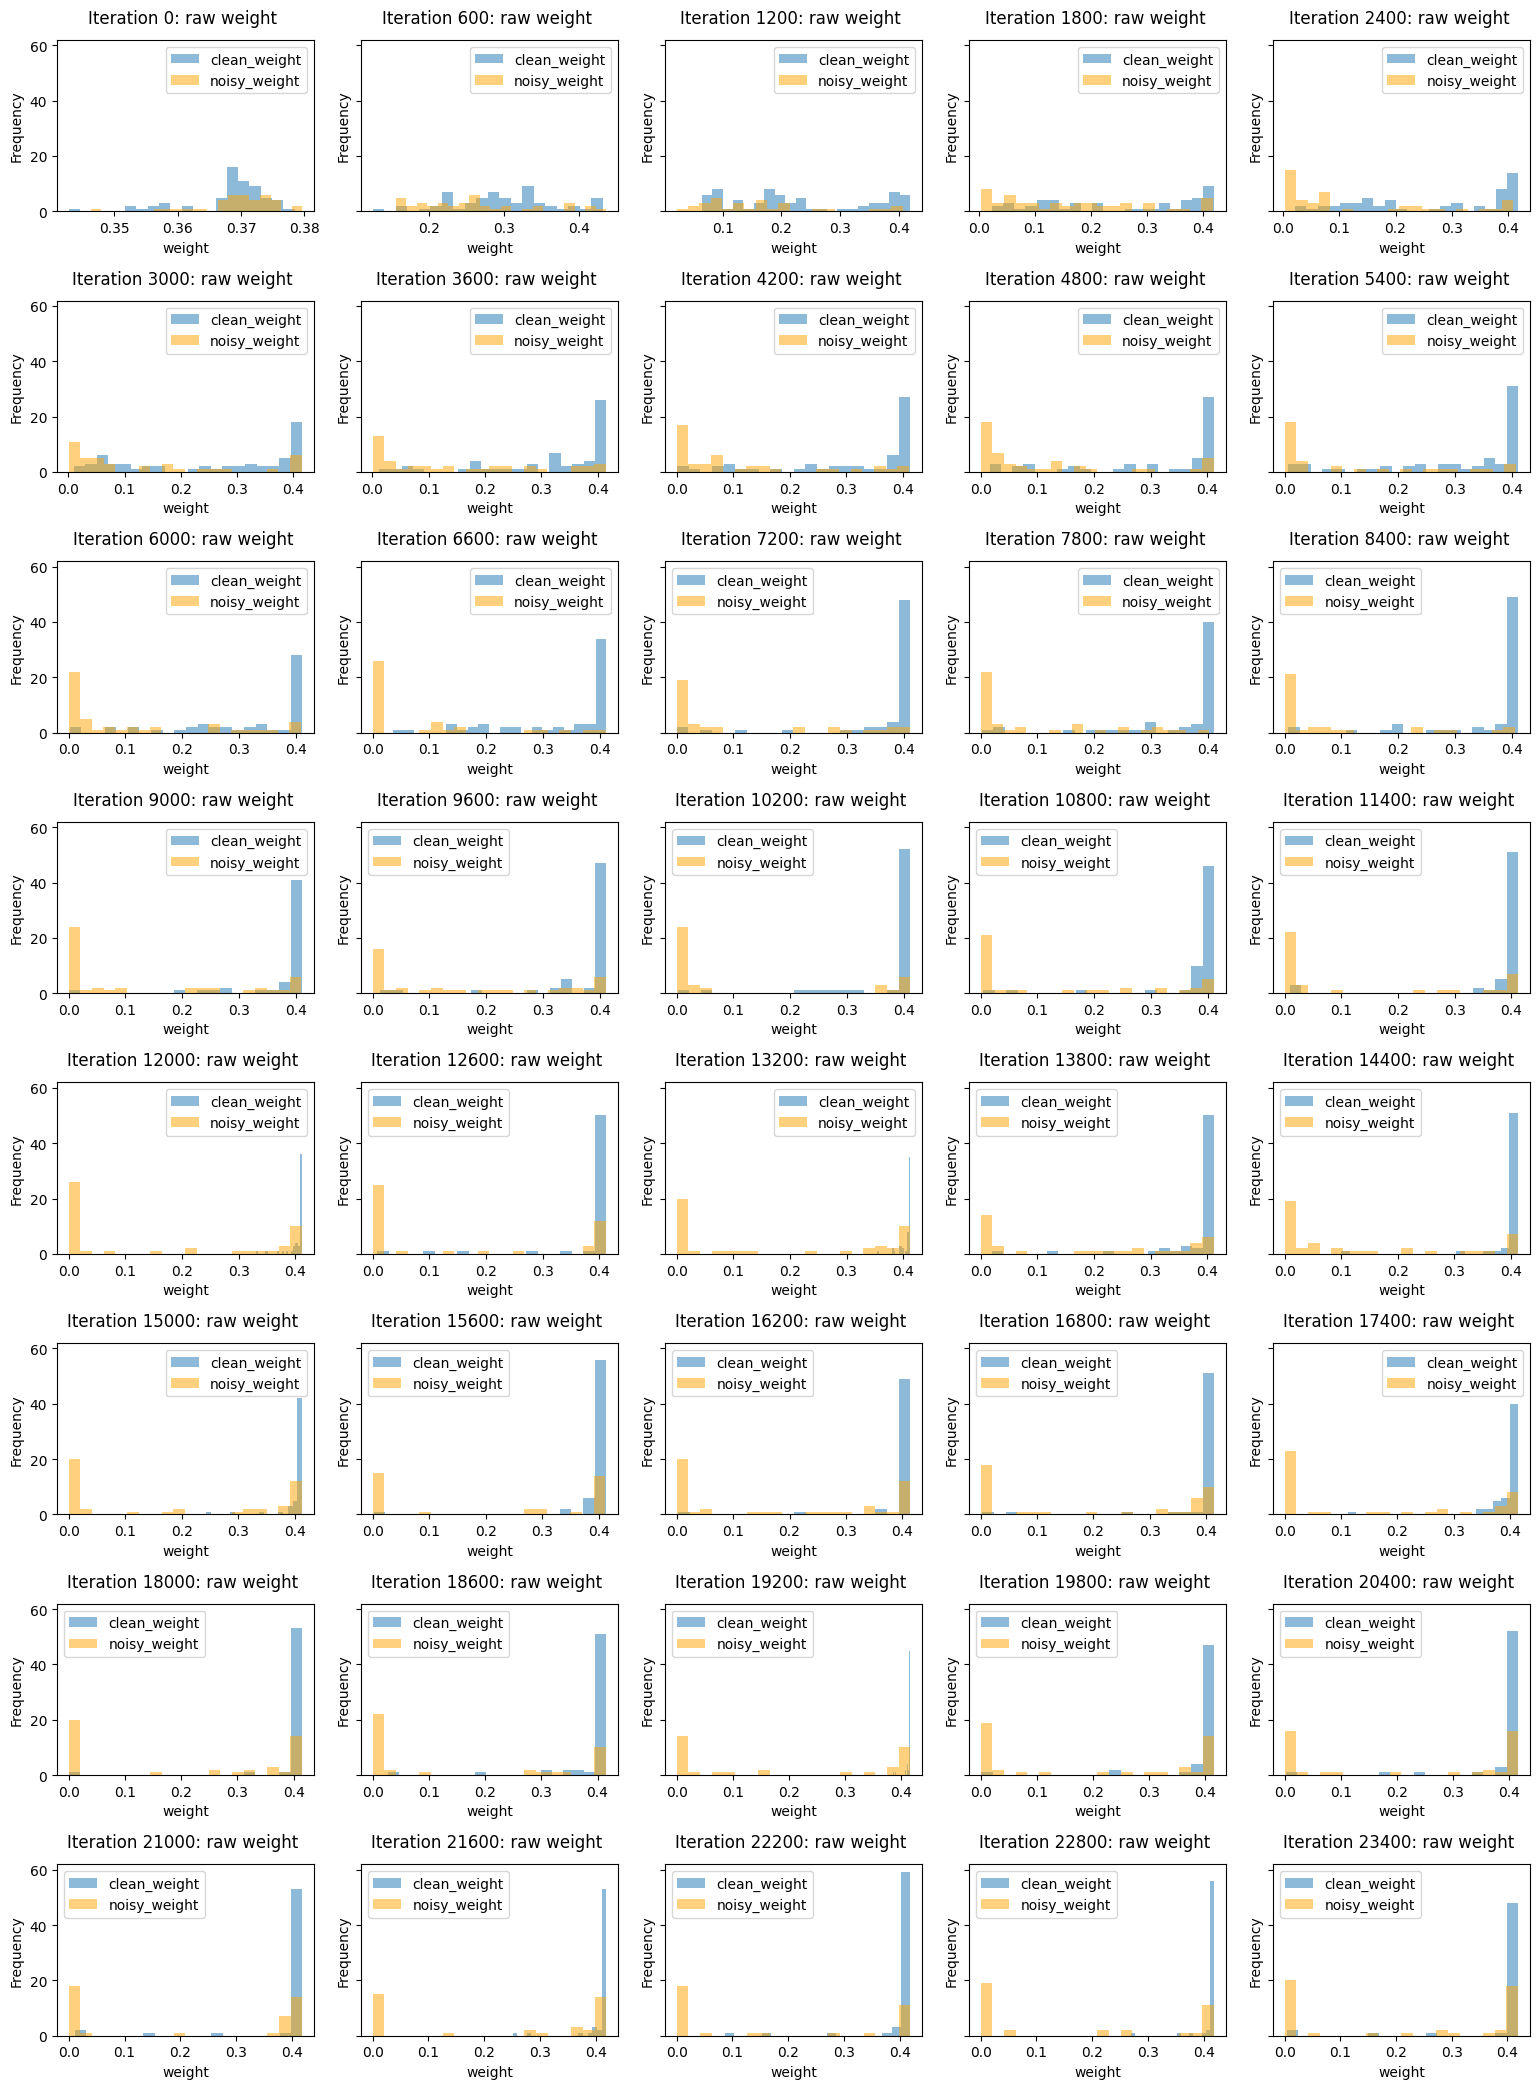

In [9]:

for prefix in ['lid_feat_l2']:
    print('------------------------------------------------',prefix)
    w_noise_lid_logits, w_clean_lid_logits = get_g_clean_noisy(weight_log,'w_{}'.format(prefix))
    w_all = weight_log['w_{}'.format(prefix)]
    weight_log['w_lid_l2_nor'] =[]

    for it in range(len(w_all)):
        total_meta = torch.clamp(w_all[it], min=0)
        norm = torch.sum(total_meta)
        if norm!=0:
            total_meta /= torch.sum(total_meta)
        else:
            total_meta = torch.zeros(len(total_meta))
        weight_log['w_lid_l2_nor'].append(total_meta)
    w_noise_lid_logits_n, w_clean_lid_logits_n= w_noise_lid_logits, w_clean_lid_logits

    noise_w_avg = [np.array(i).mean() for i in w_noise_lid_logits_n]
    noise_w_min = [np.array(i).min() for i in w_noise_lid_logits_n]
    noise_w_max = [np.array(i).max() for i in w_noise_lid_logits_n]

    clean_w_avg = [np.array(i).mean() for i in w_clean_lid_logits_n]
    clean_w_max = [np.array(i).max() for i in w_clean_lid_logits_n]
    clean_w_min = [np.array(i).min() for i in w_clean_lid_logits_n]

    # s=len(clean_w_avg)
    fig, axes = plt.subplots(1,2, figsize=(15,5),sharey=True)
    ax1, ax2 = axes.ravel()

    ax1.plot(clean_w_avg[:s],label='clean_w_avg')
    ax1.plot(clean_w_max[:s],label='clean_w_max')
    ax1.plot(clean_w_min[:s],label='clean_w_min')

    ax1.legend()
    ax1.set_title('Training Raw Weights -Clean examples')
    ax1.set_ylabel('Raw Weights')
    ax1.set_xlabel('iteration')

    ax2.plot(noise_w_avg[:s],label='noisy_w_avg')
    ax2.plot(noise_w_max[:s],label='noisy_w_max')
    ax2.plot(noise_w_min[:s],label='noisy_w_min')
    ax2.legend()
    ax2.set_title('Training Raw Weights -Noisy examples')
    ax1.set_ylabel('Raw Weights')
    ax1.set_xlabel('iteration')

    plt.show()


    clean_w_avg_s = metric_smoothing(clean_w_avg)
    clean_w_max_s =metric_smoothing(clean_w_max)

    noise_w_avg_s = metric_smoothing(noise_w_avg)
    noise_w_max_s = metric_smoothing(noise_w_max)




    fig, axes = plt.subplots(1,2, figsize=(15,5),sharey=False)
    ax1, ax2= axes.ravel()




    ax1.plot(clean_w_avg_s[:s],label='clean_w_avg_s')
    # ax3.plot(clean_w_max_s[:s],label='clean_w_max_s')
    ax1.plot(noise_w_avg_s[:s],label='noisy_w_avg_s')

    # ax1.plot(clean_w_min,label='clean_w_min')

    ax1.legend()
    ax1.set_title('Training Raw Weights (Smooth) -Avg')
    ax1.set_ylabel('Normalized Weights')
    ax1.set_xlabel('iteration')

    ax2.plot(noise_w_avg_s[:s],label='noisy_w_avg_s')
    ax2.plot(noise_w_max_s[:s],label='noisy_w_max_s')
    ax2.plot(clean_w_max_s[:s],label='clean_w_max_s')
    # ax2.plot(noise_w_min,label='noisy_w_min')
    ax2.legend()
    ax2.set_title('Training Raw Weights (Smooth) -Noisy examples')
    ax2.set_ylabel('Normalized Weights')
    ax2.set_xlabel('iteration')
    
    

    plt.show()
    plt.close()
    

    # iteration_l =list(range(0,100*int(it_perepo),max(s_,1)))
    # iteration_l =list(range(0,500,50))

    # iteration_l=list(range(40,50))
    fig, axes = plt.subplots(8, 5, tight_layout=True,sharey=True,figsize=(15.5,21))
    n_bins=20
    j=0
    for row in axes:
        for col in row:
            i = iteration_l[j]


            col.hist(w_clean_lid_logits_n[i], bins=n_bins, alpha =0.5,label ='clean_weight')
            col.hist(w_noise_lid_logits_n[i], bins=n_bins,alpha =0.5,label ='noisy_weight',color='orange')
            col.set_xlabel("weight")
            col.set_ylabel("Frequency")
            col.set_title('Iteration %i: raw weight '%(i),y=1.05 )

            col.legend(loc='best')
            j+=1
            if j==len(iteration_l):
                break
        if j==len(iteration_l):
            break 

    
    plt.show()
    
    plt.close()
    
 



## Weight Distribution

### Logits

### Further investigate the relatonship between LID(xi) and Noisy label


dict_keys(['true_label', 'train_labels', 'clean_indices', 'iteration', 'sample_idx', 'w_ce_loss', 'w_lid_logits_l2', 'w_lid_feat_l2', 'w_lid_logits_cos', 'w_lid_feat_cos', 'lid_feat_l2', 'lid_feat_cos', 'lid_logits_l2', 'lid_logits_cos', 'unl_ce_loss', 'labi_loss', 'labi_lid_logits_l2', 'labi_lid_feat_l2', 'labi_lid_logits_cos', 'labi_lid_feat_cos'])

In [10]:
noise_loss_feat,clean_loss_feat = get_g_clean_noisy(weight_log,'labi_loss')
# noise_lidfl2_feat,clean_lidfl2_feat = get_g_clean_noisy(weight_log,'labi_lid_logits_l2')

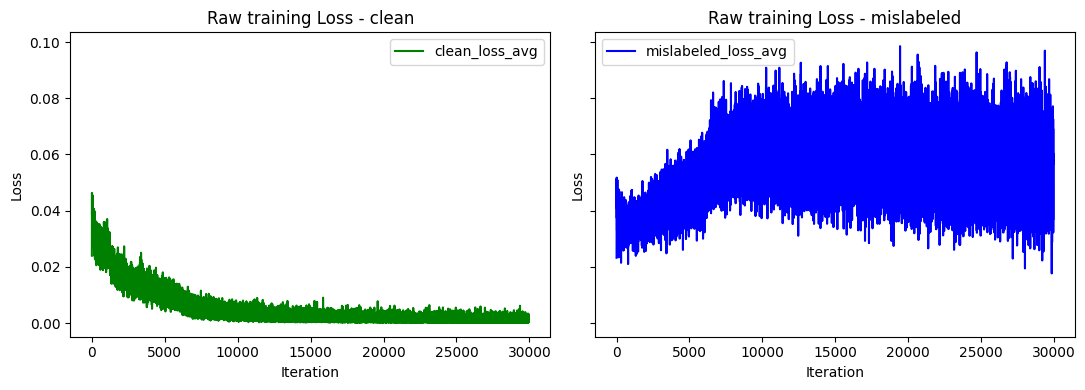

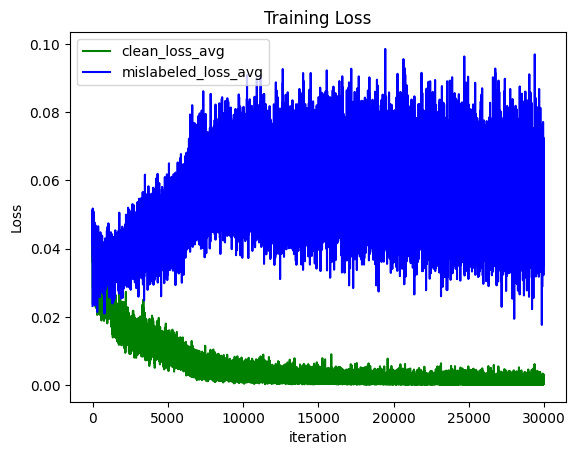

In [11]:
clean_loss_avg = [np.array(i).mean()/b for i in clean_loss_feat]
noise_loss_avg = [np.array(i).mean()/b for i in noise_loss_feat]
clean_loss_max = [np.array(i).max()/b for i in clean_loss_feat]
clean_loss_min = [np.array(i).min()/b for i in clean_loss_feat]

fig, axes = plt.subplots(1,2, figsize=(11,4), tight_layout=True, sharey=True,sharex=True)
ax1, ax2 = axes.ravel()

ax1.plot(clean_loss_avg, c='green',label='clean_loss_avg') 
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iteration")
ax1.legend()
# ax1.set_ylim(0,0.28)
ax1.set_title('Raw training Loss - clean')

ax2.plot(noise_loss_avg, c='blue',label='mislabeled_loss_avg') 
ax2.set_ylabel("Loss")
ax2.set_xlabel("Iteration")
ax2.legend()
ax2.set_title('Raw training Loss - mislabeled')
plt.show()



plt.plot(clean_loss_avg,label='clean_loss_avg',c='green')
plt.plot(noise_loss_avg, c='blue',label='mislabeled_loss_avg')
plt.title('Training Loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('iteration')
# plt.ylim(0,2)
plt.show()

## Weighed Loss


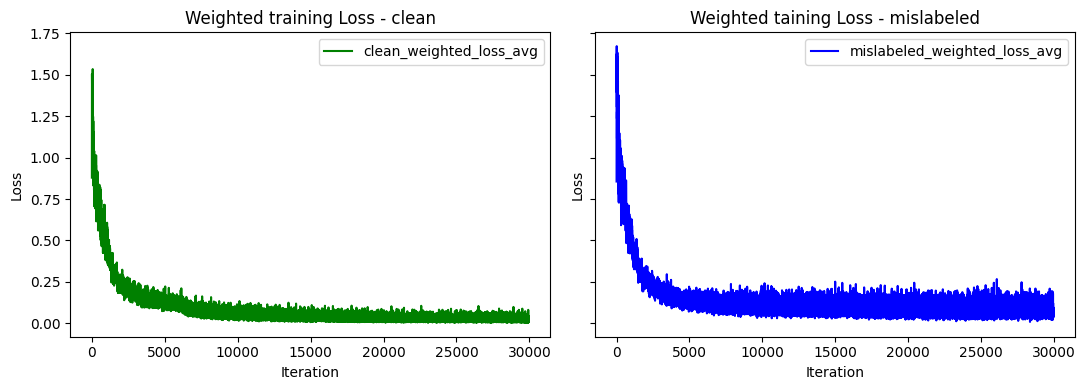

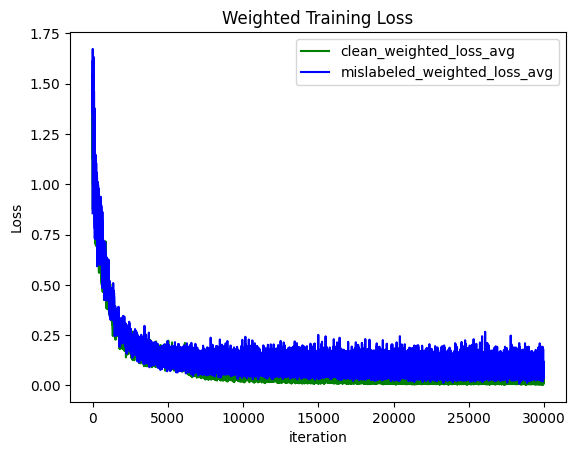

In [12]:
prefix = 'lid_feat_l2'
w_all_ = weight_log['w_{}'.format(prefix)]
# weight_log['w_lid_l2_minmax'] = []
weight_log['weighted_loss'] = []

for it in range(len(w_all_)):
    # total_meta_ = (w_all_[it]-w_all_[it].min())/(w_all_[it].max()-w_all_[it].min())
    # if torch.sum(total_meta_)>0:
    #     total_meta_ /= torch.sum(total_meta_)
    # else: 
    #     total_meta_ =torch.zeros(len(total_meta_))

    weight_log['weighted_loss'].append(torch.squeeze(w_all_[it])*weight_log['labi_loss'][it])

    
noise_weighted_loss_feat,clean_weighted_loss_feat = get_g_clean_noisy(weight_log,'weighted_loss')

clean_wloss_avg = [np.array(i).mean() for i in clean_weighted_loss_feat]
noise_wloss_avg = [np.array(i).mean() for i in noise_weighted_loss_feat]


fig, axes = plt.subplots(1,2, figsize=(11,4), tight_layout=True, sharey=True,sharex=False)
ax1, ax2 = axes.ravel()

ax1.plot(clean_wloss_avg, c='green',label='clean_weighted_loss_avg') 
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iteration")
ax1.legend()
# ax1.set_ylim(0,0.28)
ax1.set_title('Weighted training Loss - clean')

ax2.plot(noise_wloss_avg, c='blue',label='mislabeled_weighted_loss_avg') 
ax2.set_ylabel("Loss")
ax2.set_xlabel("Iteration")
ax2.legend()
ax2.set_title('Weighted taining Loss - mislabeled')
plt.show()



plt.plot(clean_wloss_avg,label='clean_weighted_loss_avg',c='green')
plt.plot(noise_wloss_avg, c='blue',label='mislabeled_weighted_loss_avg')
plt.title('Weighted Training Loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('iteration')
# plt.ylim(0,2)
plt.show()


In [13]:
# clean_lid_avg = [np.array(i).mean() for i in clean_lidfl2_feat]
# noise_lid_avg = [np.array(i).mean() for i in noise_lidfl2_feat]
# clean_lid_max = [np.array(i).max() for i in clean_lidfl2_feat]
# clean_lid_min = [np.array(i).min() for i in clean_lidfl2_feat]

# plt.plot(clean_lid_avg,label='clean_lid_avg')
# plt.plot(clean_lid_max,label='clean_lid_max')
# plt.plot(clean_lid_min,label='clean_lid_min')

# plt.legend()
# plt.title('Training LID(logits) -Clean examples')
# plt.ylabel('LID')
# plt.xlabel('iteration')
# # plt.ylim(0,2)
# plt.show()

# plt.plot(noise_lid_avg,label='noise_lid_avg', c='blue')
# plt.title('Training LID(logits) - Noisy examples')
# plt.ylabel('LID')
# # plt.xlabel('iteration')
# # plt.ylim(0,2)
# plt.show()


In [14]:
# noise_lidfl2_feat,clean_lidfl2_feat = get_g_clean_noisy(weight_log,'labi_lid_feat_l2')
# clean_lid_avg_ = [np.array(i).mean() for i in clean_lidfl2_feat]
# noise_lid_avg_ = [np.array(i).mean() for i in noise_lidfl2_feat]
# clean_lid_max_ = [np.array(i).max() for i in clean_lidfl2_feat]
# clean_lid_min_ = [np.array(i).min() for i in clean_lidfl2_feat]

# plt.plot(clean_lid_avg_,label='clean_lid_avg')
# plt.plot(clean_lid_max_,label='clean_lid_max')
# plt.plot(clean_lid_min_,label='clean_lid_min')

# plt.legend()
# plt.title('Training LID(feat) -Clean examples')
# plt.ylabel('LID')
# plt.xlabel('iteration')
# # plt.ylim(0,2)
# plt.show()

# plt.plot(noise_lid_avg_,label='noise_lid_avg', c='blue')
# plt.title('Training LID(feat) - Noisy examples')
# plt.ylabel('LID')
# # plt.xlabel('iteration')
# # plt.ylim(0,2)
# plt.show()


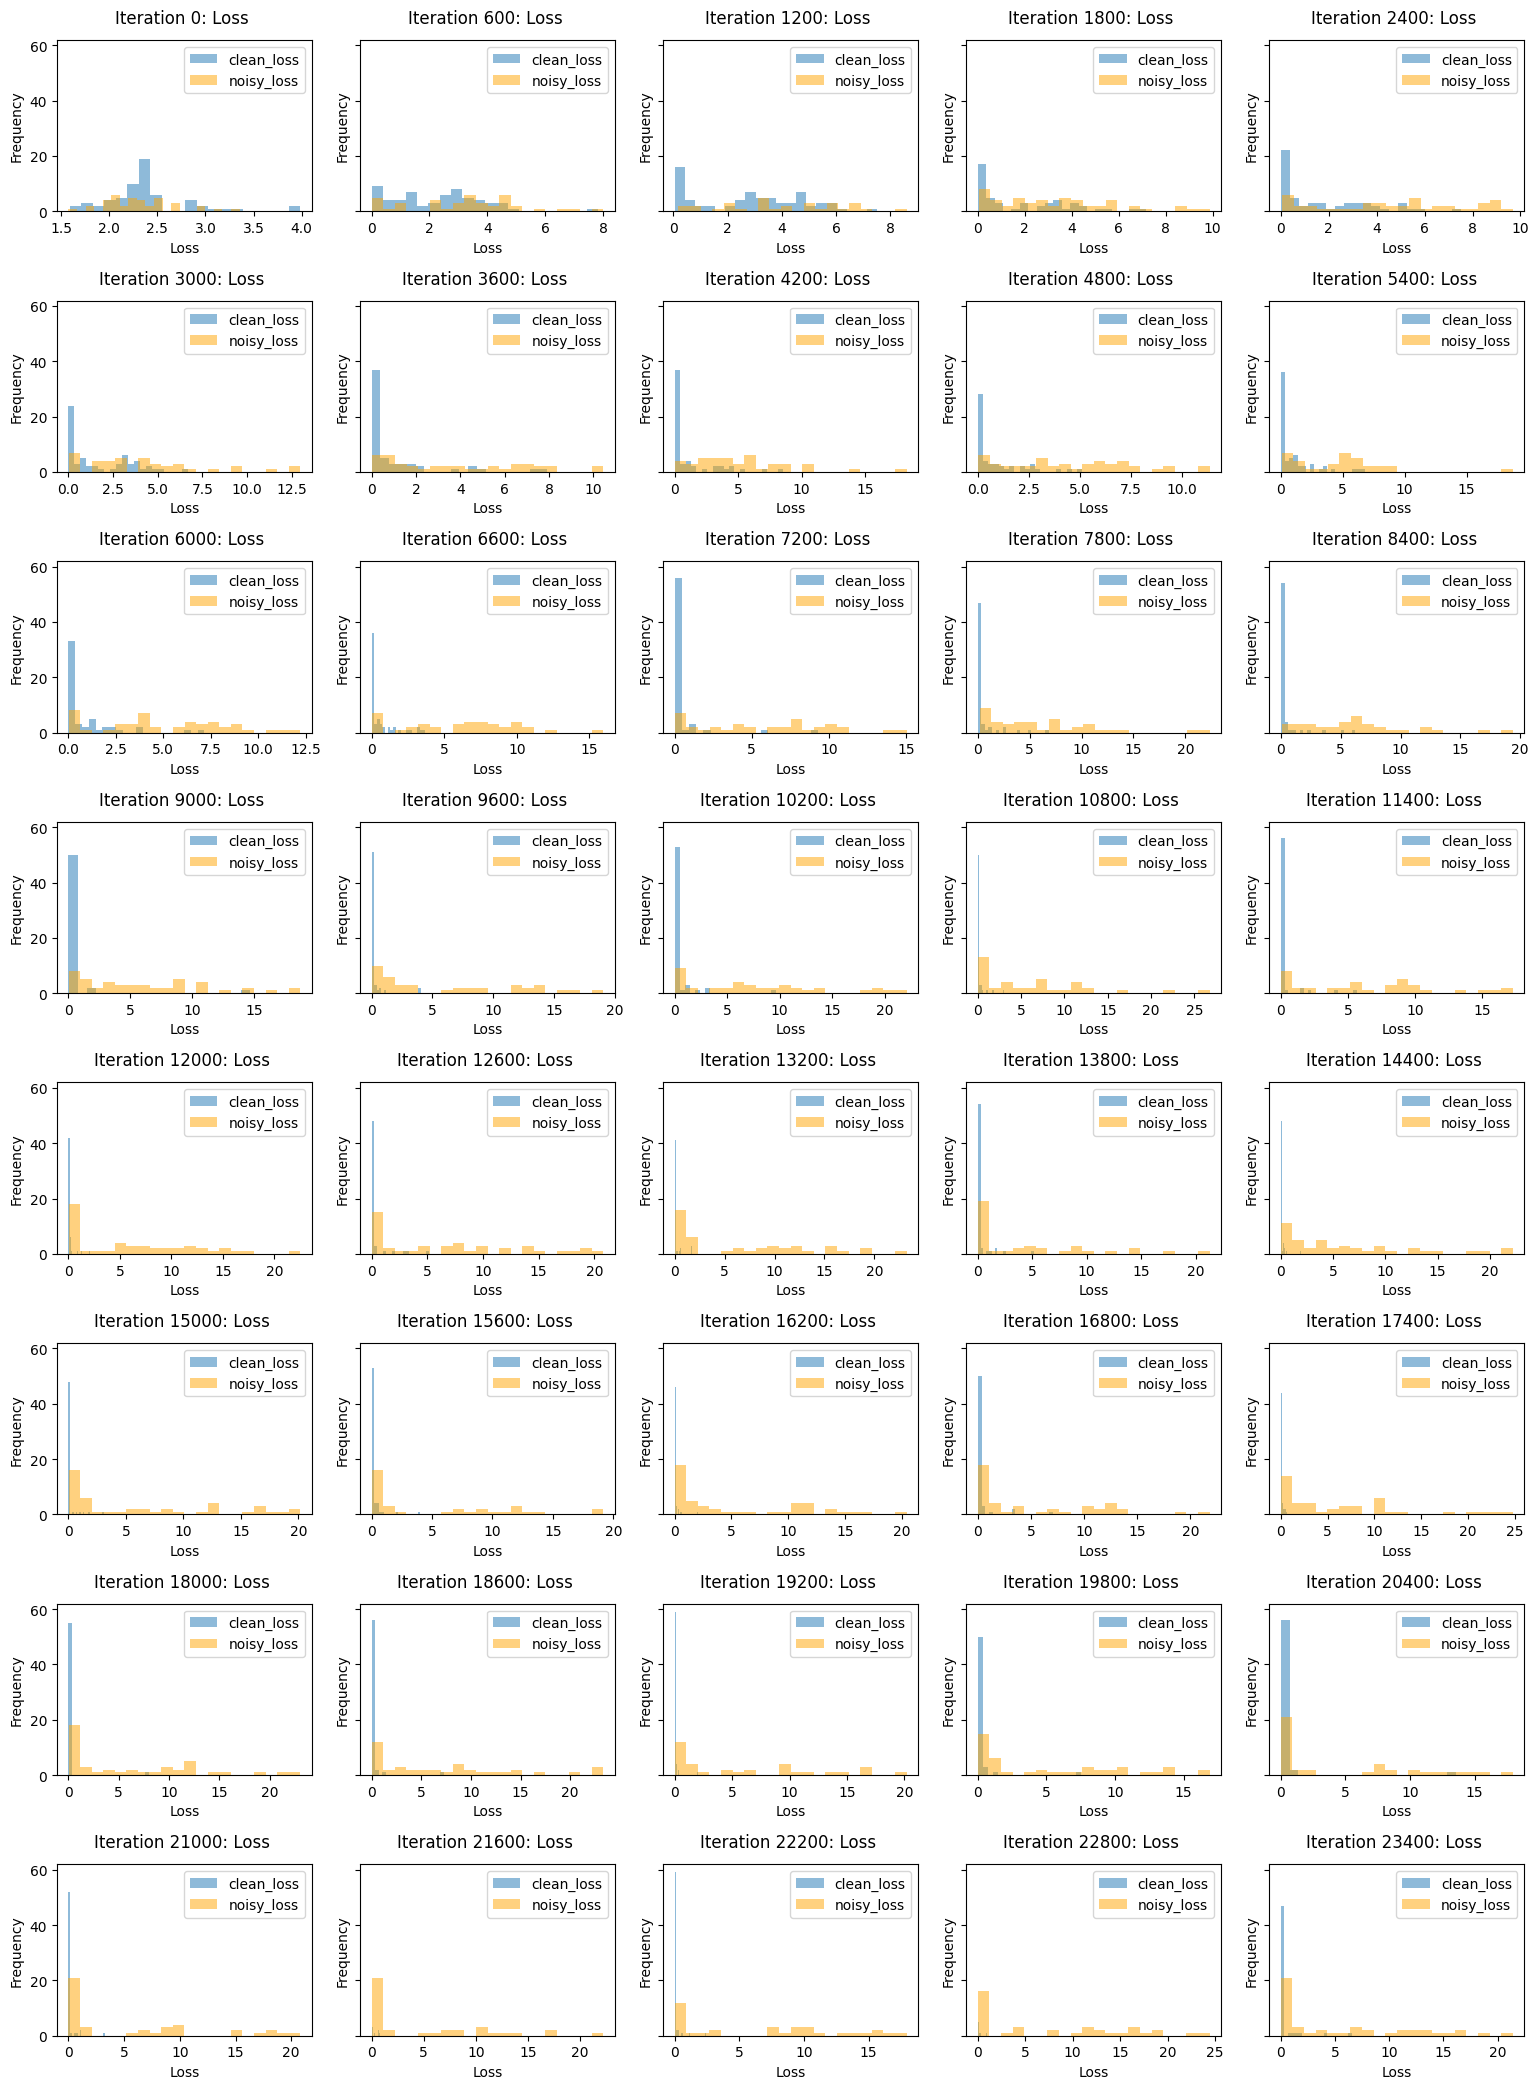

In [15]:
# it_perepo= num_labels/batch_size
# s_= int(it_perepo/2)

# iteration_l =list(range(0,100*int(it_perepo),max(s_,1)))
# iteration_l=list(range(0,500,50))
fig, axes = plt.subplots(8, 5, tight_layout=True,sharex=False,sharey=True,figsize=(15.5,21))
n_bins=20
j=0
for row in axes:
    for col in row:

            
        i = iteration_l[j]
        col.hist(clean_loss_feat[i], bins=n_bins, alpha =0.5,label ='clean_loss')
        col.hist(noise_loss_feat[i], bins=n_bins,alpha =0.5,label ='noisy_loss',color='orange')
        col.set_xlabel("Loss")
        col.set_ylabel("Frequency")
        col.set_title('Iteration %i: Loss '%(i),y=1.05 )

        col.legend(loc='best')
        j+=1
        if j== len(iteration_l):
            break
    if j== len(iteration_l):
        break            
plt.show()
plt.close()


In [16]:
# it_perepo= num_labels/batch_size
# s_= int(it_perepo/2)

# iteration_l =list(range(0,100*int(it_perepo),max(s_,1)))

# fig, axes = plt.subplots(8, 5, tight_layout=True,sharex=True,sharey=True,figsize=(15.5,21))

# for row in axes:
#     for col in row:
#         if iteration_l:
#             i = iteration_l.pop(0)
#             col.hist(clean_lidfl2_feat[i], bins=n_bins, alpha =0.5,label ='clean_lid')
#             col.hist(noise_lidfl2_feat[i], bins=n_bins,alpha =0.5,label ='noisy_lid',color='orange')
#             col.set_xlabel("LID")
#             col.set_ylabel("Frequency")
#             col.set_title('Iteration %i: LID '%(i),y=1.05 )

#             col.legend(loc='best')
# plt.show()
# plt.close()


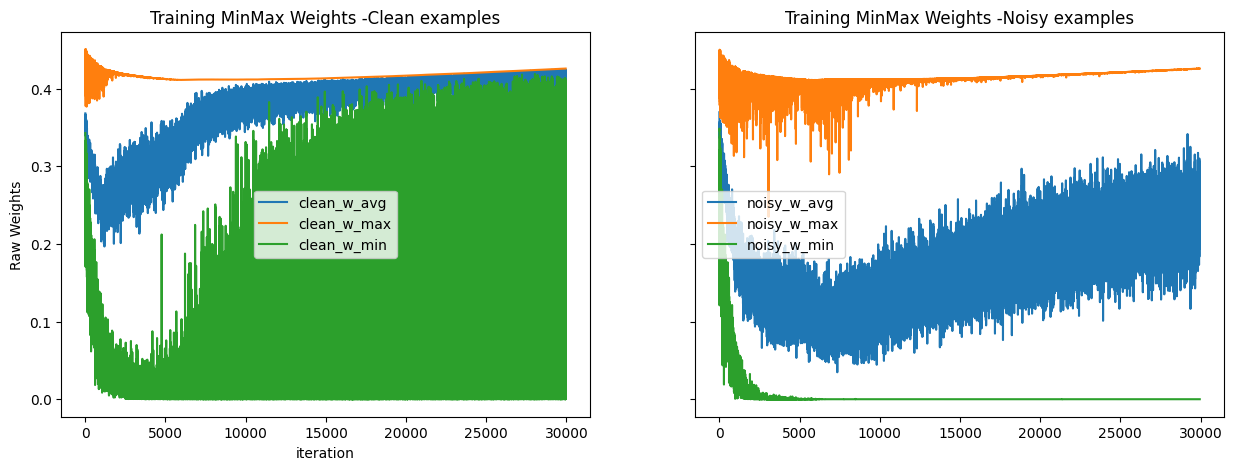

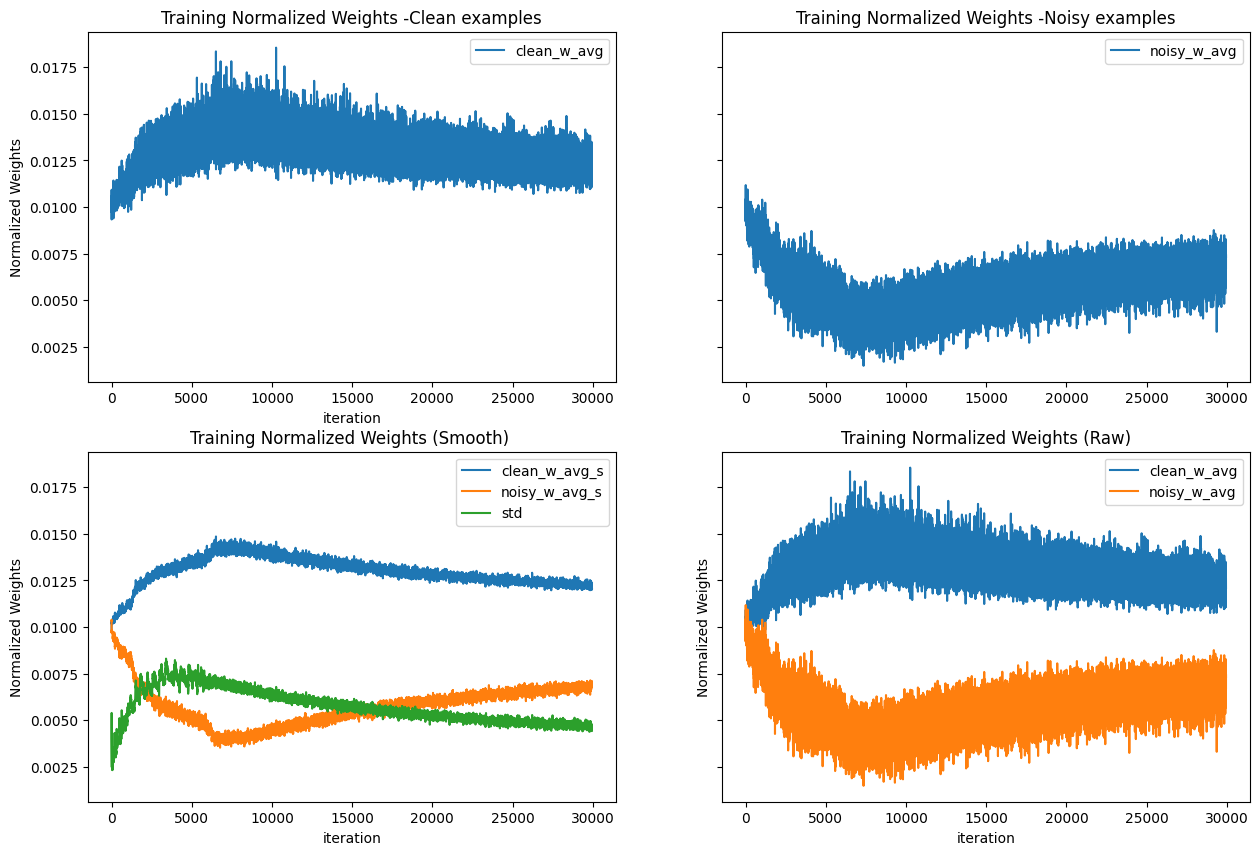

------------------------------------------------ lid_feat_l2


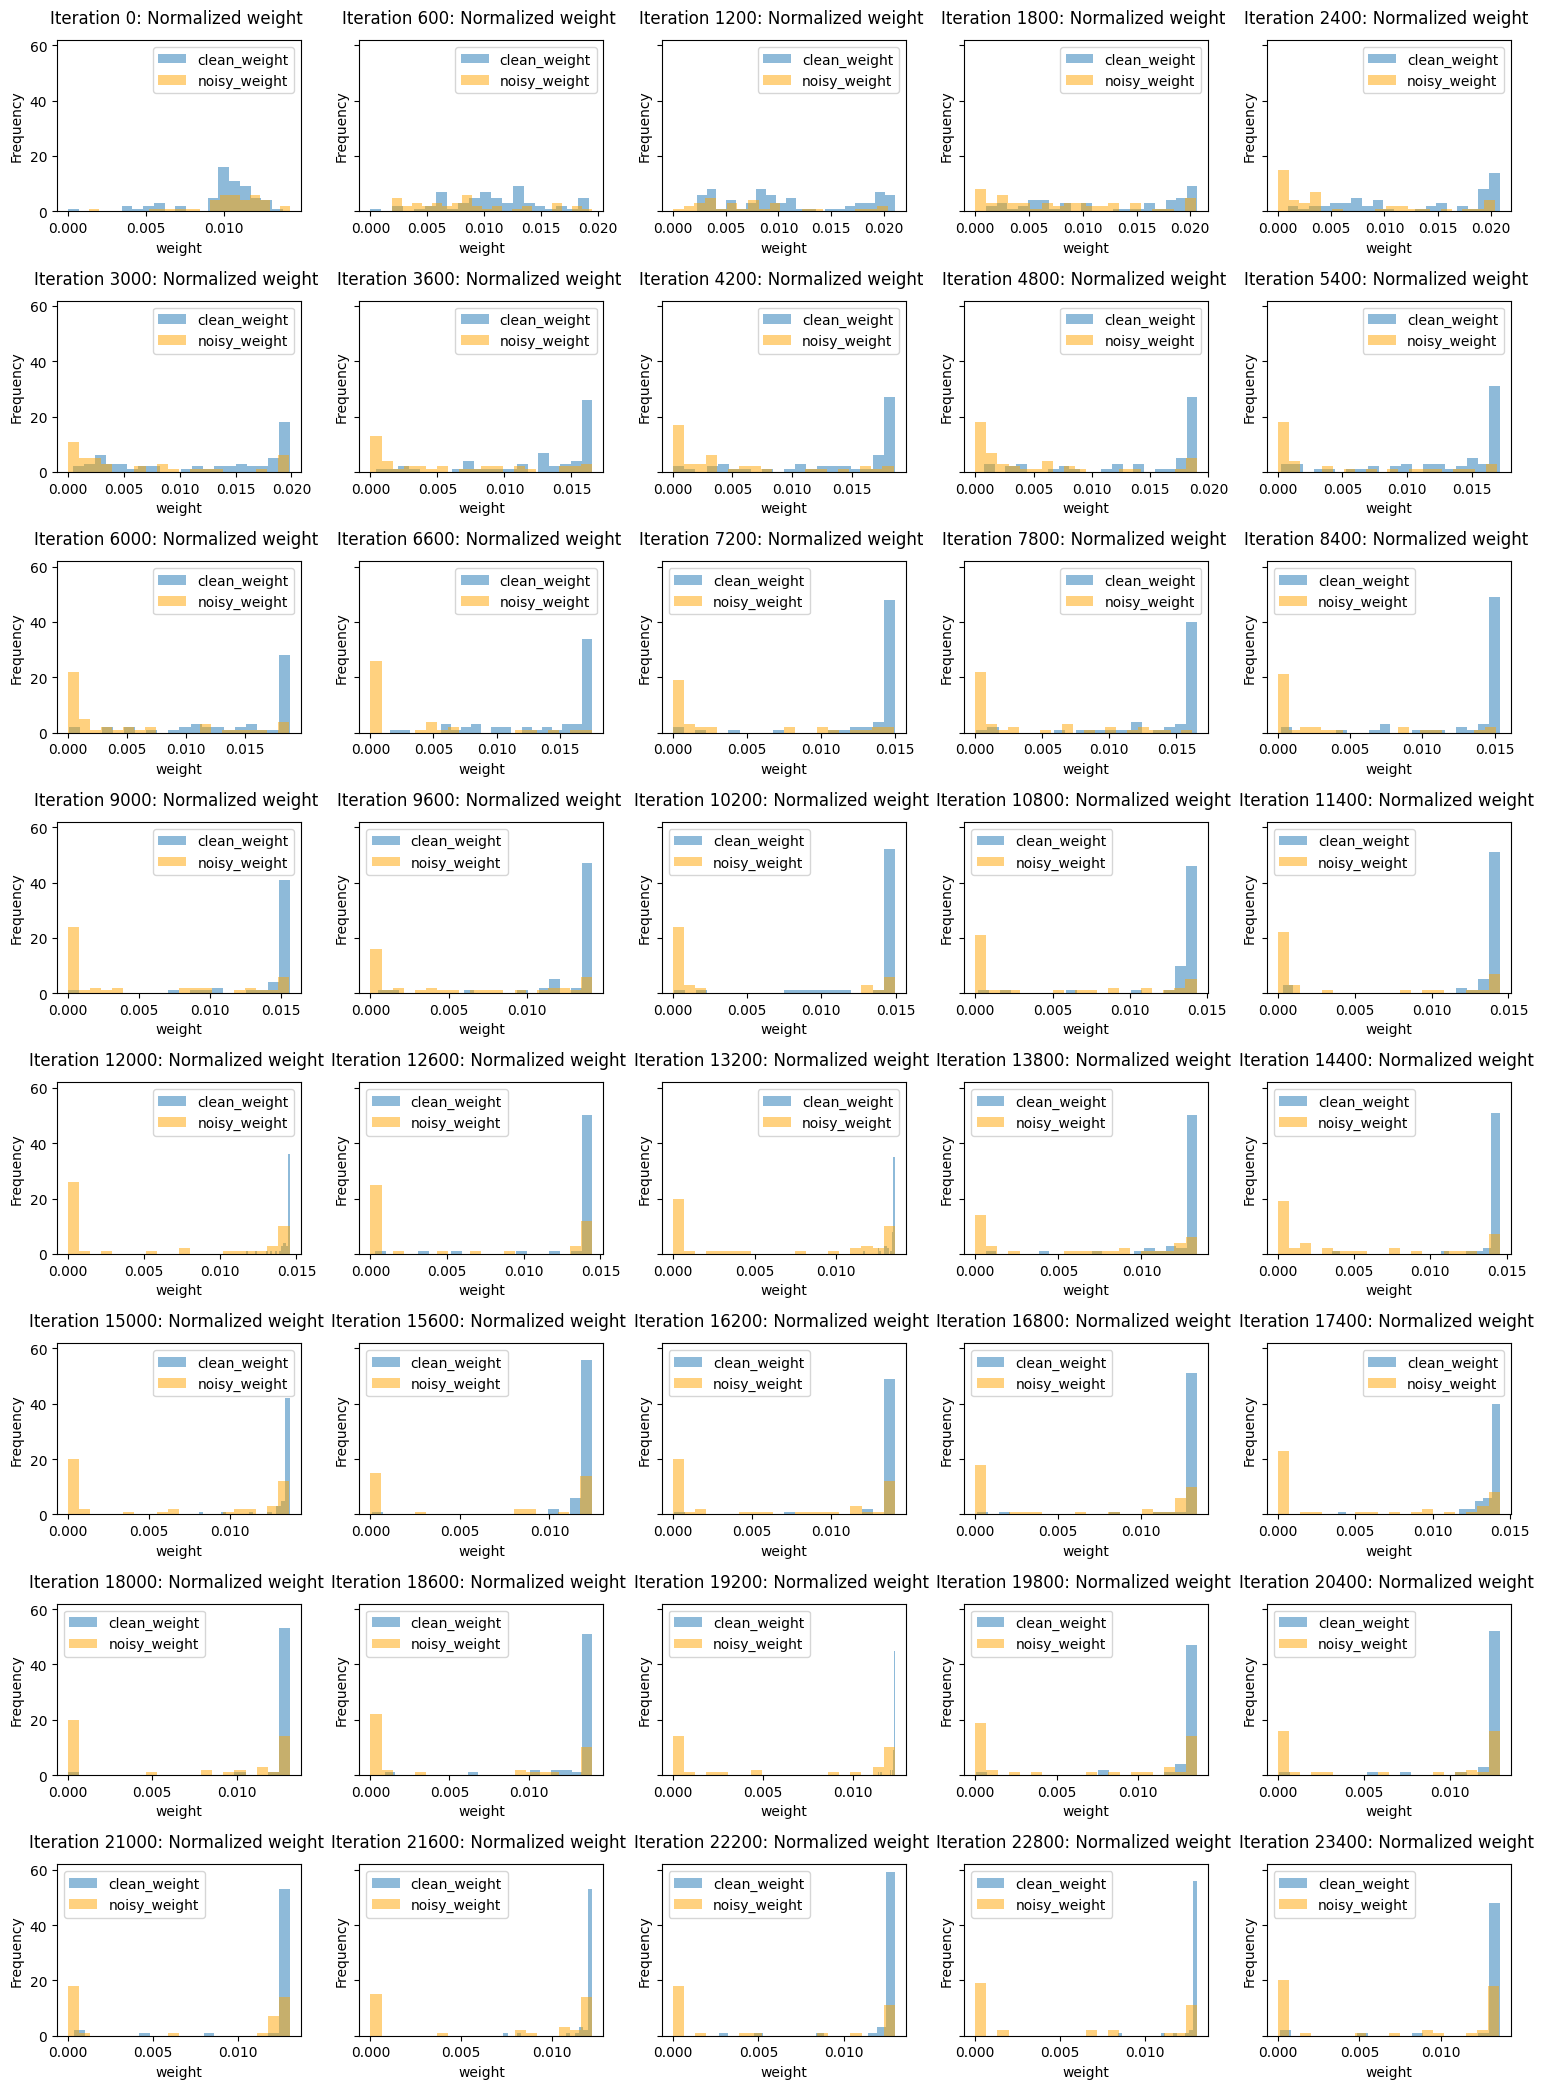

In [17]:

normal_='minmax'
weight_log['w_{}_{}'.format(prefix,normal_)] = []
w_all = weight_log['w_{}'.format(prefix)]

for it in range(len(w_all)):
    # total_meta =F.softmax(w_all[it],dim=-1)
    total_meta = (w_all[it]-w_all[it].min())
    if torch.sum(total_meta)>0:
        total_meta /= torch.sum(total_meta)
    else:
        total_meta =torch.zeros(len(total_meta_))
    weight_log['w_{}_{}'.format(prefix,normal_)].append(total_meta)


w_noise_lid_logits_n, w_clean_lid_logits_n = get_g_clean_noisy(weight_log,'w_{}_{}'.format(prefix,normal_))
std_ = [i.std() for i in weight_log['w_{}_{}'.format(prefix,normal_)]]


s=len(w_all)
fig, axes = plt.subplots(1,2, figsize=(15,5),sharey=True)
ax1, ax2 = axes.ravel()

ax1.plot(clean_w_avg[:s],label='clean_w_avg')
ax1.plot(clean_w_max[:s],label='clean_w_max')
ax1.plot(clean_w_min[:s],label='clean_w_min')

ax1.legend()
ax1.set_title('Training MinMax Weights -Clean examples')
ax1.set_ylabel('Raw Weights')
ax1.set_xlabel('iteration')

ax2.plot(noise_w_avg[:s],label='noisy_w_avg')
ax2.plot(noise_w_max[:s],label='noisy_w_max')
ax2.plot(noise_w_min[:s],label='noisy_w_min')
ax2.legend()
ax2.set_title('Training MinMax Weights -Noisy examples')
ax1.set_ylabel('Raw Weights')
ax1.set_xlabel('iteration')

plt.show()
    
noise_w_avg = [np.array(i).mean() for i in w_noise_lid_logits_n]
noise_w_min = [np.array(i).min() for i in w_noise_lid_logits_n]
noise_w_max = [np.array(i).max() for i in w_noise_lid_logits_n]

clean_w_avg = [np.array(i).mean() for i in w_clean_lid_logits_n]
clean_w_max = [np.array(i).max() for i in w_clean_lid_logits_n]
clean_w_min = [np.array(i).min() for i in w_clean_lid_logits_n]

clean_w_avg_s = metric_smoothing(clean_w_avg)
clean_w_max_s =metric_smoothing(clean_w_max)

noise_w_avg_s = metric_smoothing(noise_w_avg)
noise_w_max_s = metric_smoothing(noise_w_max)
std_s = metric_smoothing(std_)



fig, axes = plt.subplots(2,2, figsize=(15,10),sharey=True)
ax1, ax2,ax3,ax4 = axes.ravel()

ax1.plot(clean_w_avg[:s],label='clean_w_avg')
# ax1.plot(clean_w_max[:s],label='clean_w_max')
# ax1.plot(clean_w_min,label='clean_w_min')

ax1.legend()
ax1.set_title('Training Normalized Weights -Clean examples')
ax1.set_ylabel('Normalized Weights')
ax1.set_xlabel('iteration')

ax2.plot(noise_w_avg[:s],label='noisy_w_avg')
# ax2.plot(noise_w_max[:s],label='noisy_w_max')
# ax2.plot(noise_w_min,label='noisy_w_min')
ax2.legend()
ax2.set_title('Training Normalized Weights -Noisy examples')
ax1.set_ylabel('Normalized Weights')
ax1.set_xlabel('iteration')


ax3.plot(clean_w_avg_s[:s],label='clean_w_avg_s')
# ax3.plot(clean_w_max_s[:s],label='clean_w_max_s')
ax3.plot(noise_w_avg_s[:s],label='noisy_w_avg_s')
ax3.plot(std_s[:s],label='std')

# ax1.plot(clean_w_min,label='clean_w_min')

ax3.legend()
ax3.set_title('Training Normalized Weights (Smooth) ')
ax3.set_ylabel('Normalized Weights')
ax3.set_xlabel('iteration')


ax4.plot(clean_w_avg[:s],label='clean_w_avg')
ax4.plot(noise_w_avg[:s],label='noisy_w_avg')

# ax4.plot(noise_w_max_s[:s],label='noisy_w_max_s')
# ax2.plot(noise_w_min,label='noisy_w_min')
ax4.legend()
ax4.set_title('Training Normalized Weights (Raw)')
ax4.set_ylabel('Normalized Weights')
ax4.set_xlabel('iteration')
plt.show()
plt.close()

print('------------------------------------------------',prefix)
# w_noise_lid_logits, w_clean_lid_logits = get_g_clean_noisy(weight_log,'w_{}'.format(prefix))
# it_perepo= num_labels/batch_size
# s_= int(it_perepo/2)

# iteration_l =list(range(0,100*int(it_perepo),max(s_,1)))
# iteration_l =list(range(0,1700,50))

# iteration_l=list(range(40,50))
fig, axes = plt.subplots(8, 5, tight_layout=True,sharex=False,sharey=True,figsize=(15.5,21))
n_bins=20
j=0
for row in axes:
    for col in row:
        
            
        i = iteration_l[j]
        col.hist(w_clean_lid_logits_n[i], bins=n_bins, alpha =0.5,label ='clean_weight')
        col.hist(w_noise_lid_logits_n[i], bins=n_bins,alpha =0.5,label ='noisy_weight',color='orange')
        col.set_xlabel("weight")
        col.set_ylabel("Frequency")
        col.set_title('Iteration %i: Normalized weight '%(i),y=1.05 )

        col.legend(loc='best')
        j+=1
        if j== len(iteration_l):
            break
    if j== len(iteration_l):
        break
plt.show()

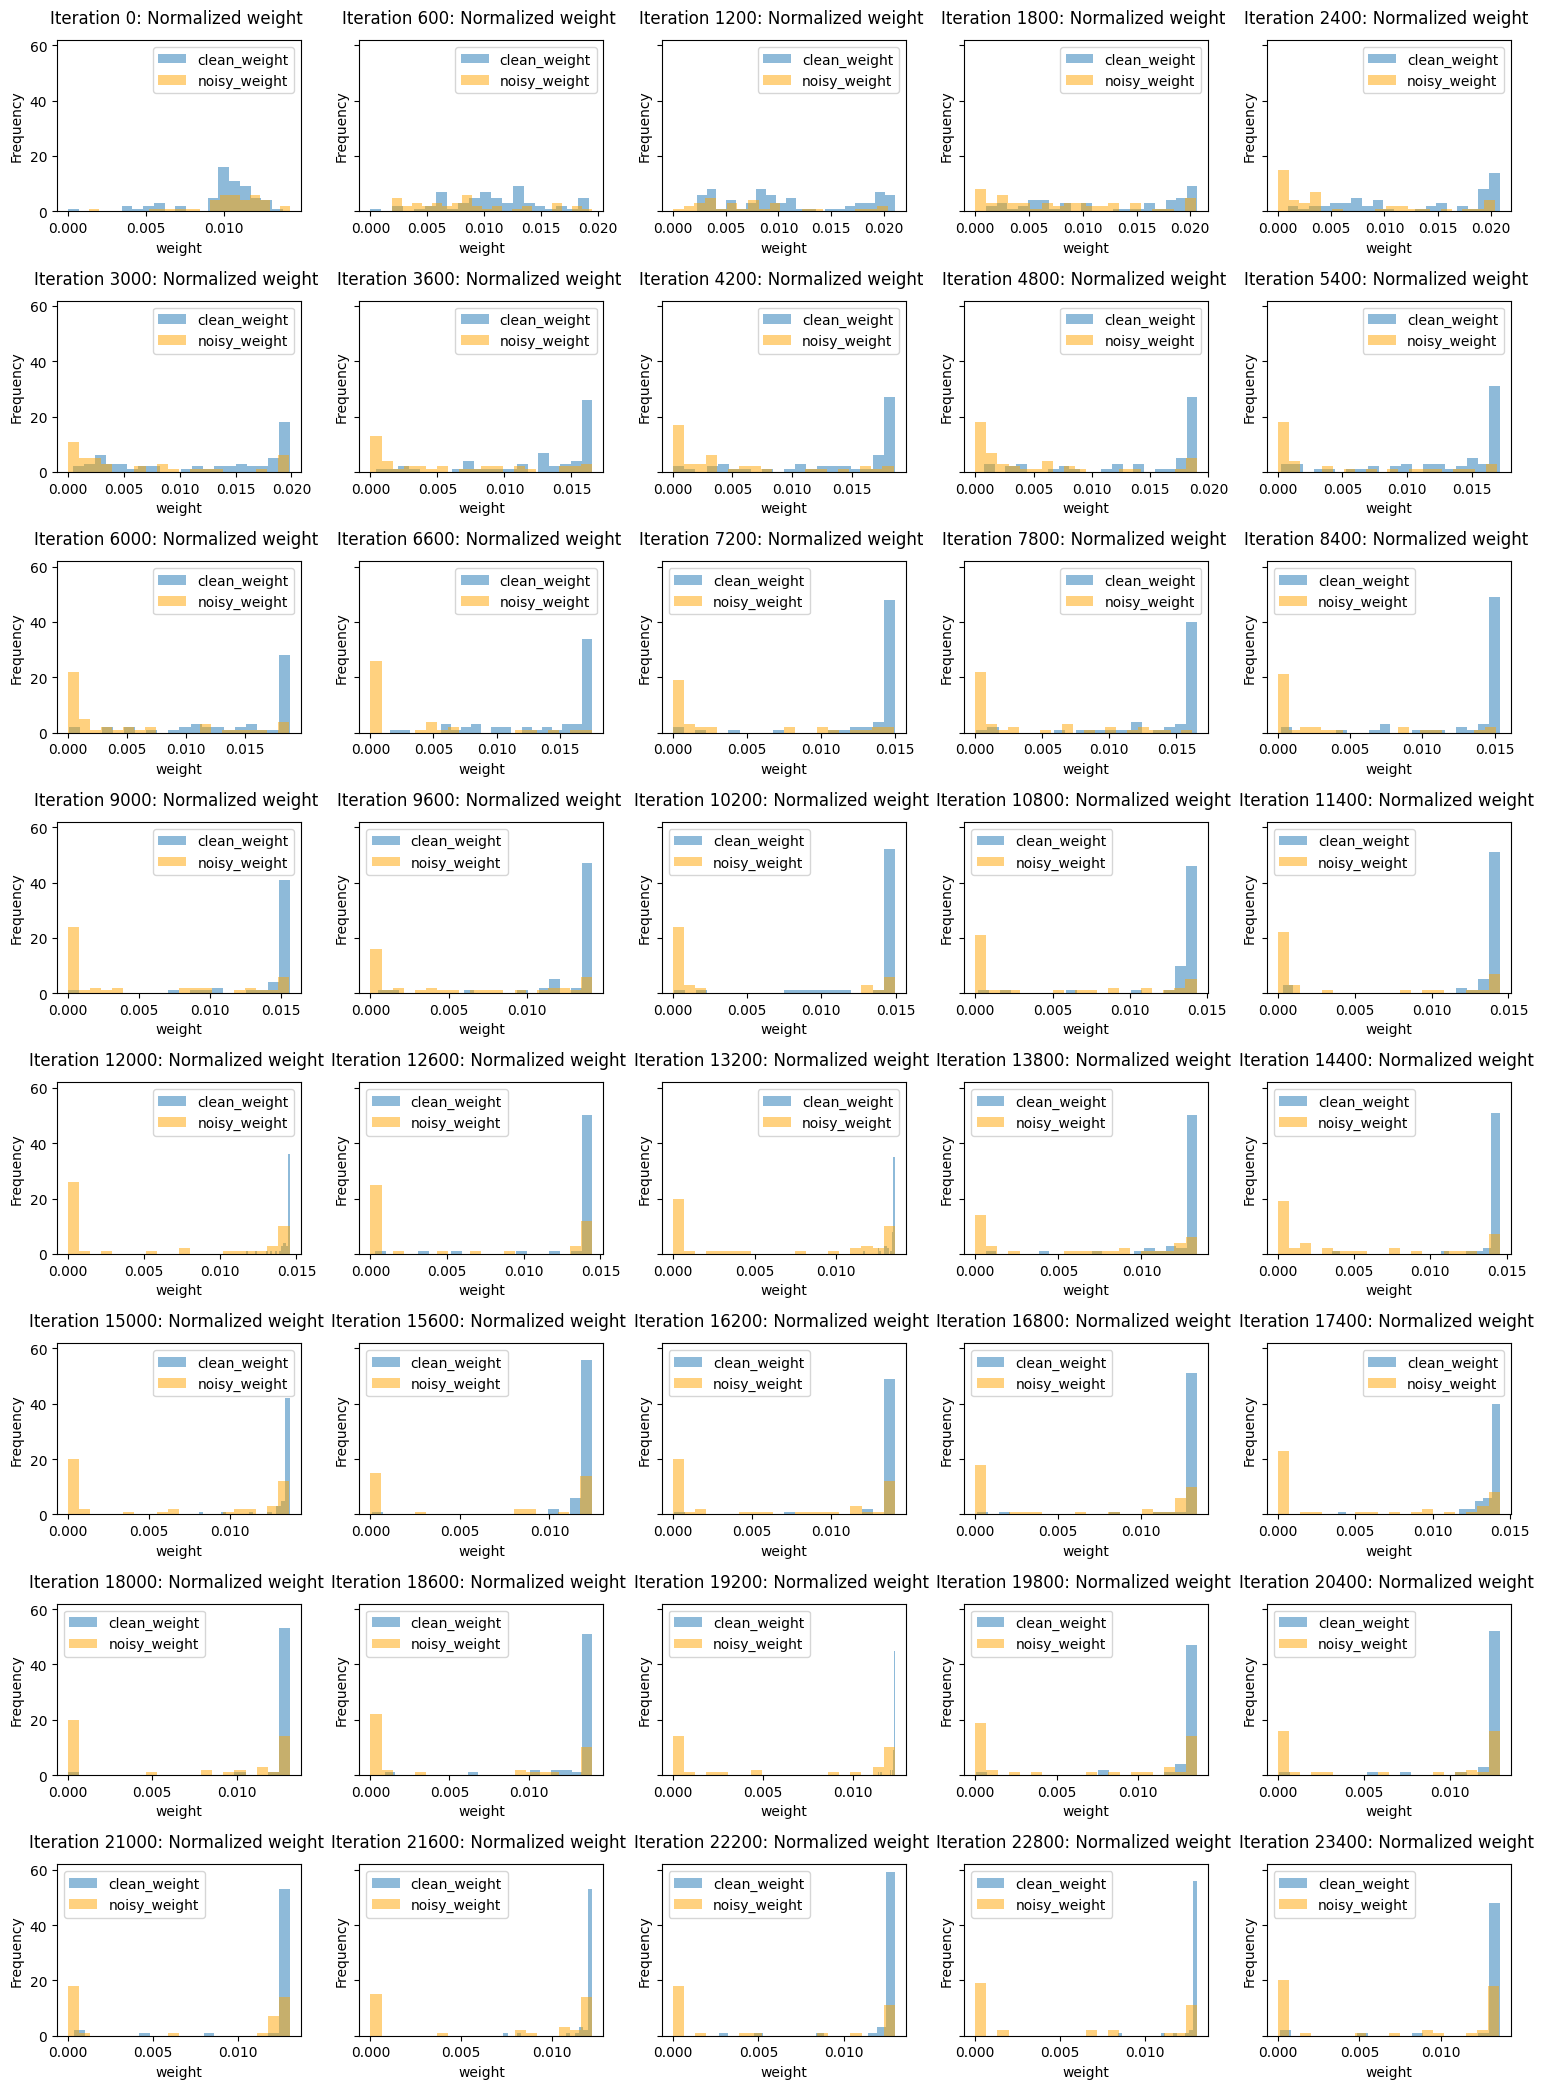

In [18]:
# iteration_l = range(0,3000,50)
fig, axes = plt.subplots(8, 5, tight_layout=True,sharex=False,sharey=True,figsize=(15.5,21))
n_bins=20
j=0
for row in axes:
    for col in row:
        
            
        i = iteration_l[j]
        col.hist(w_clean_lid_logits_n[i], bins=n_bins, alpha =0.5,label ='clean_weight')
        col.hist(w_noise_lid_logits_n[i], bins=n_bins,alpha =0.5,label ='noisy_weight',color='orange')
        col.set_xlabel("weight")
        col.set_ylabel("Frequency")
        col.set_title('Iteration %i: Normalized weight '%(i),y=1.05 )

        col.legend(loc='best')
        j+=1
        if j== len(iteration_l):
            break
    if j== len(iteration_l):
        break
plt.show()

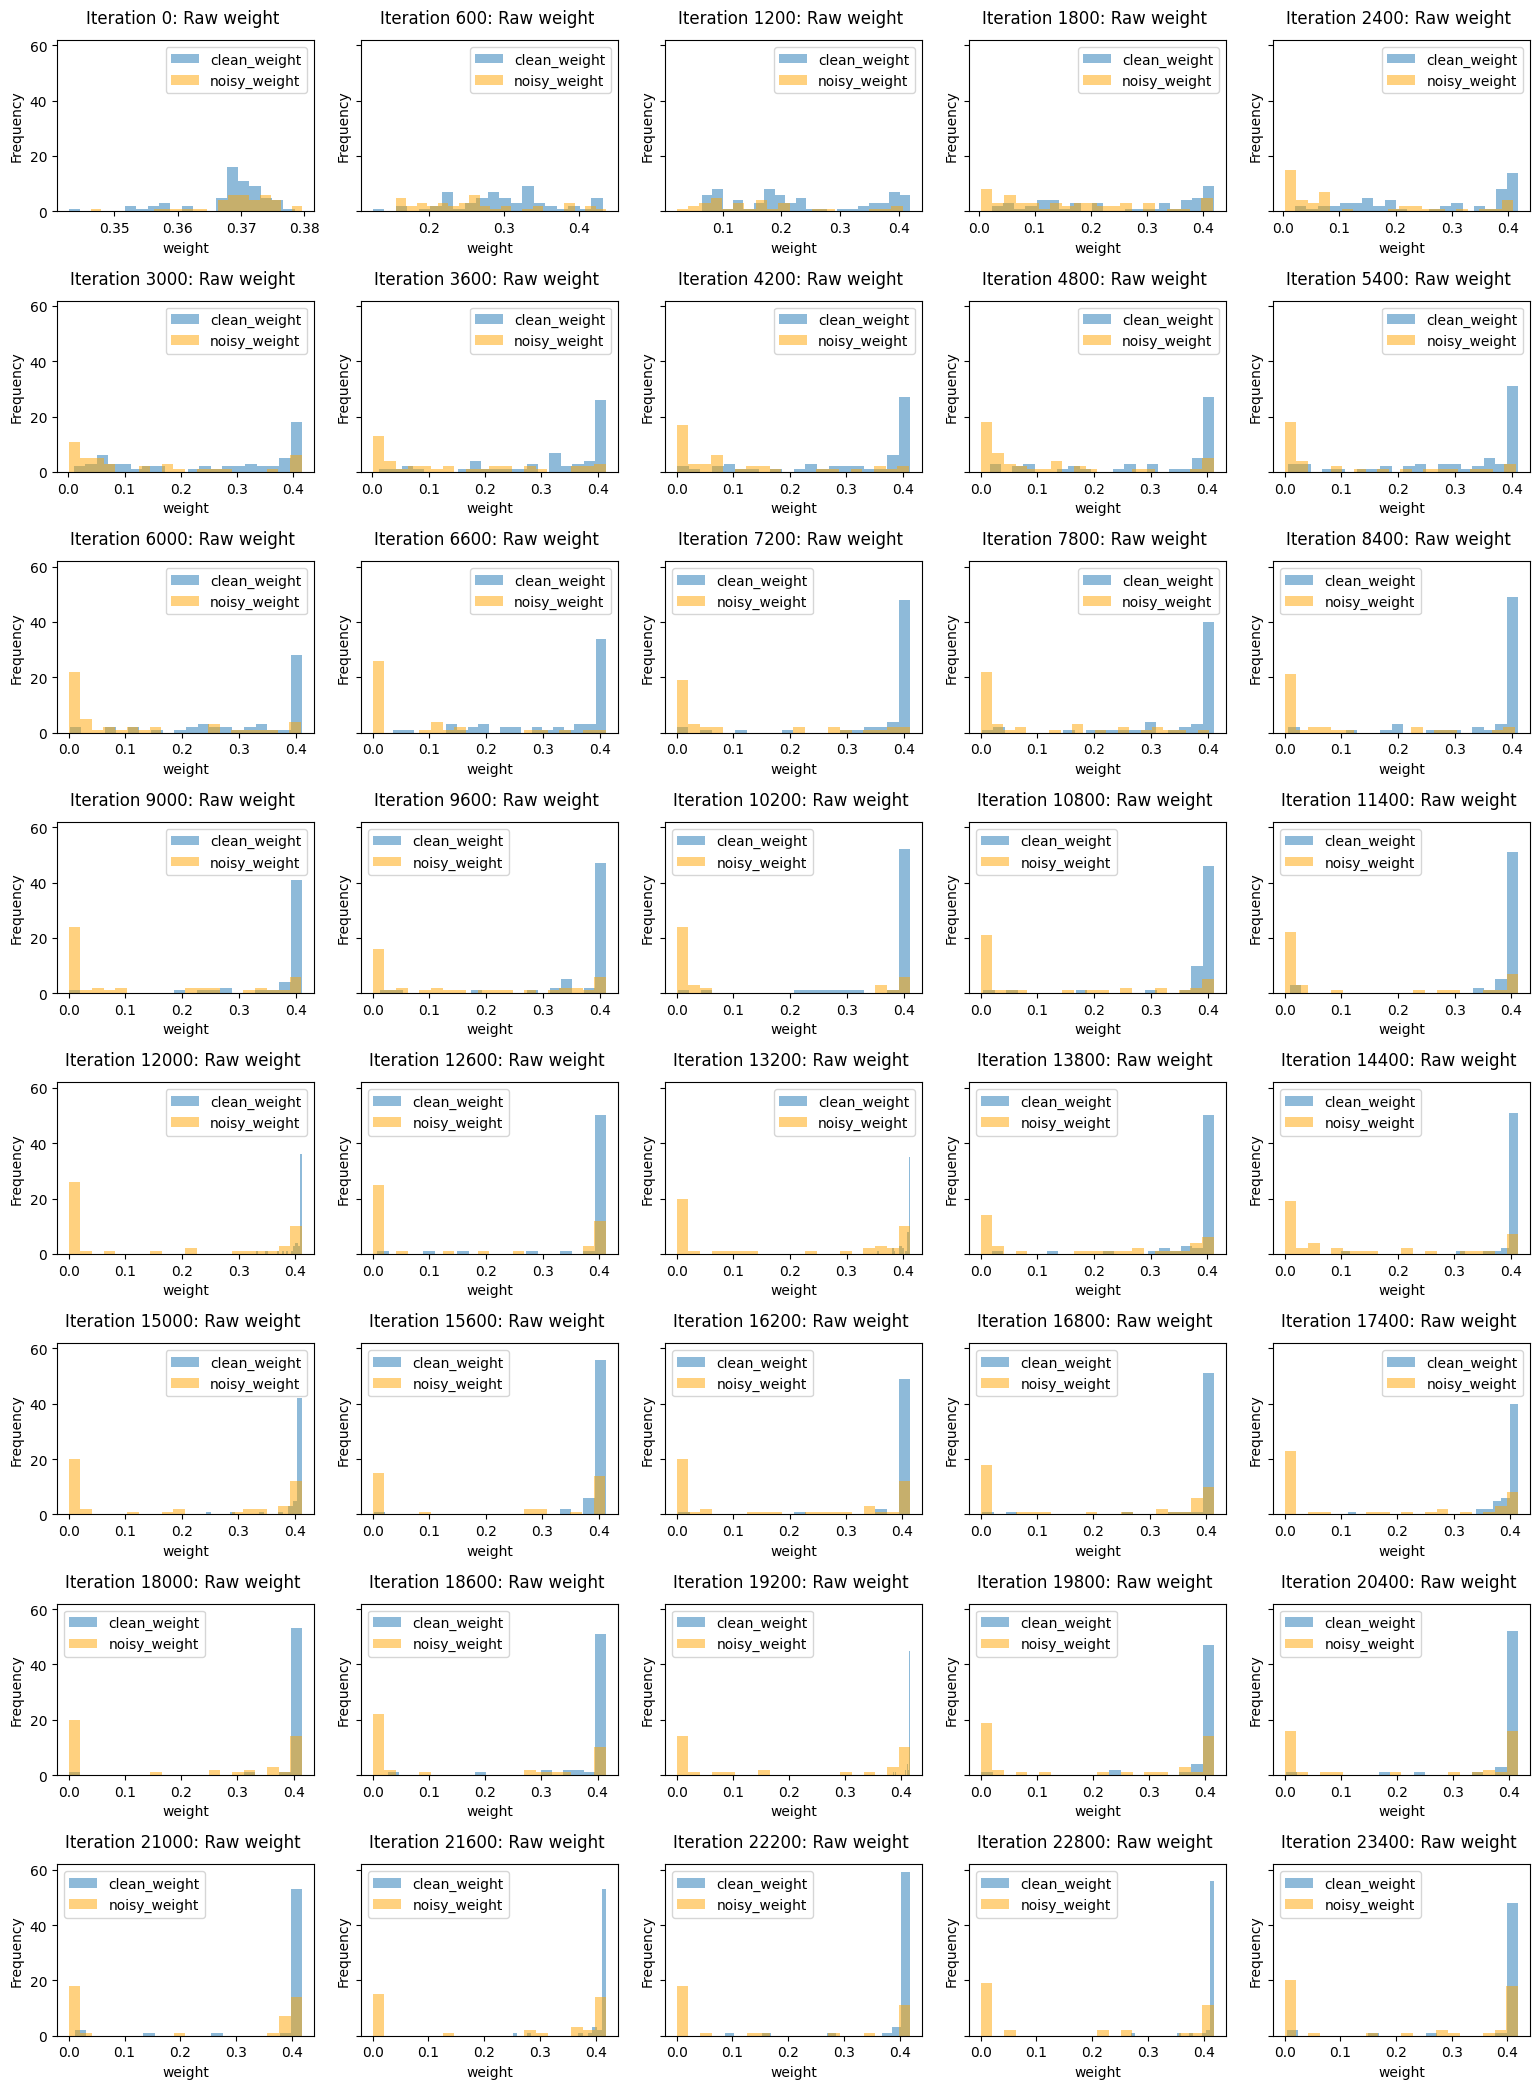

In [19]:
# iteration_l = range(0,3000,50)
fig, axes = plt.subplots(8, 5, tight_layout=True,sharex=False,sharey=True,figsize=(15.5,21))
n_bins=20
j=0
for row in axes:
    for col in row:
        
            
        i = iteration_l[j]
        col.hist(w_clean_lid_logits[i], bins=n_bins, alpha =0.5,label ='clean_weight')
        col.hist(w_noise_lid_logits[i], bins=n_bins,alpha =0.5,label ='noisy_weight',color='orange')
        col.set_xlabel("weight")
        col.set_ylabel("Frequency")
        col.set_title('Iteration %i: Raw weight '%(i),y=1.05 )

        col.legend(loc='best')
        j+=1





        
        if j== len(iteration_l):
            break
    if j== len(iteration_l):
        break
plt.show()

raw:'w_lid_feat_l2'

zero:'w_lid_l2_nor'

minmax: 'w_lid_feat_l2_minmax'



In [20]:
key_='w_lid_feat_l2'
noisy_sample_dict, clean_sample_dict  = get_weight_dict(weight_log,key_)  


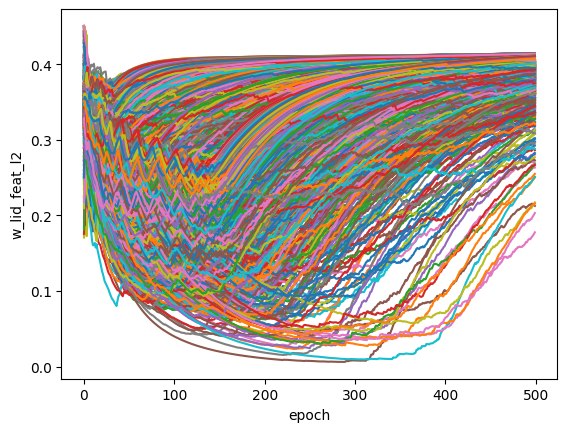

identified n_clean: 2322 real n_clean: 2351


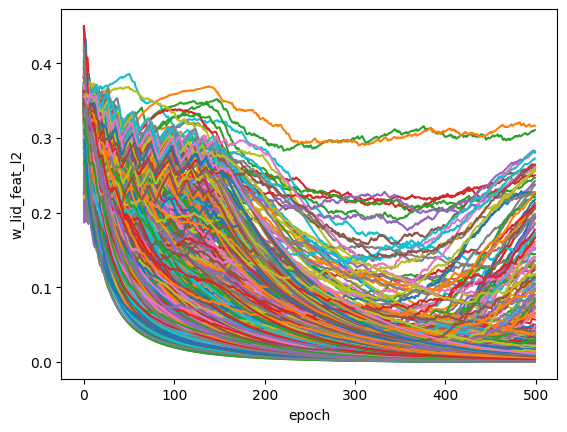

identified n_noisy: 888 real n_noisy: 1649


In [21]:

es= int(d_s/b)

t0 = int(0/es) #5000 iter
t1= int(20000/es)   # 8000 iter
avg = 0
smoothing_alpha=0.99
n_clean=0
# avg_pstd=avg +
# avg_mstd=avg +

for key,val in clean_sample_dict.items():
    # std = np.std(metric_smoothing(val[t0:t1]))
    if np.mean(metric_smoothing(val[t0:t1],smoothing_alpha))<np.mean(val[t0:t1]):
    # if np.mean(val[t0:t1])>avg:
        plt.plot(metric_smoothing(val[t0:t1],smoothing_alpha),label=key)
        # plt.plot(val[:190],label=key)
        plt.xlabel('epoch')
        plt.ylabel(key_)

    # plt.ylim(0,0.017)

        n_clean+=1
plt.show()
plt.close()

print('identified n_clean:',n_clean,'real n_clean:',len(clean_sample_dict.keys()))

n_noisy=0

for key,val in noisy_sample_dict.items():
    if np.mean(metric_smoothing(val[t0:t1],smoothing_alpha))>np.mean(val[t0:t1]):
    # if np.mean(val[t0:t1])<=avg:
        plt.plot(metric_smoothing(val[t0:t1],smoothing_alpha),label=key)
        plt.xlabel('epoch')
        plt.ylabel(key_)
        # plt.ylim(0,0.07)
        n_noisy+=1
plt.show()
print('identified n_noisy:',n_noisy, 'real n_noisy:',len(noisy_sample_dict.keys()))


raw:'w_lid_feat_l2'

zero:'w_lid_l2_nor'

minmax: 'w_lid_feat_l2_minmax'

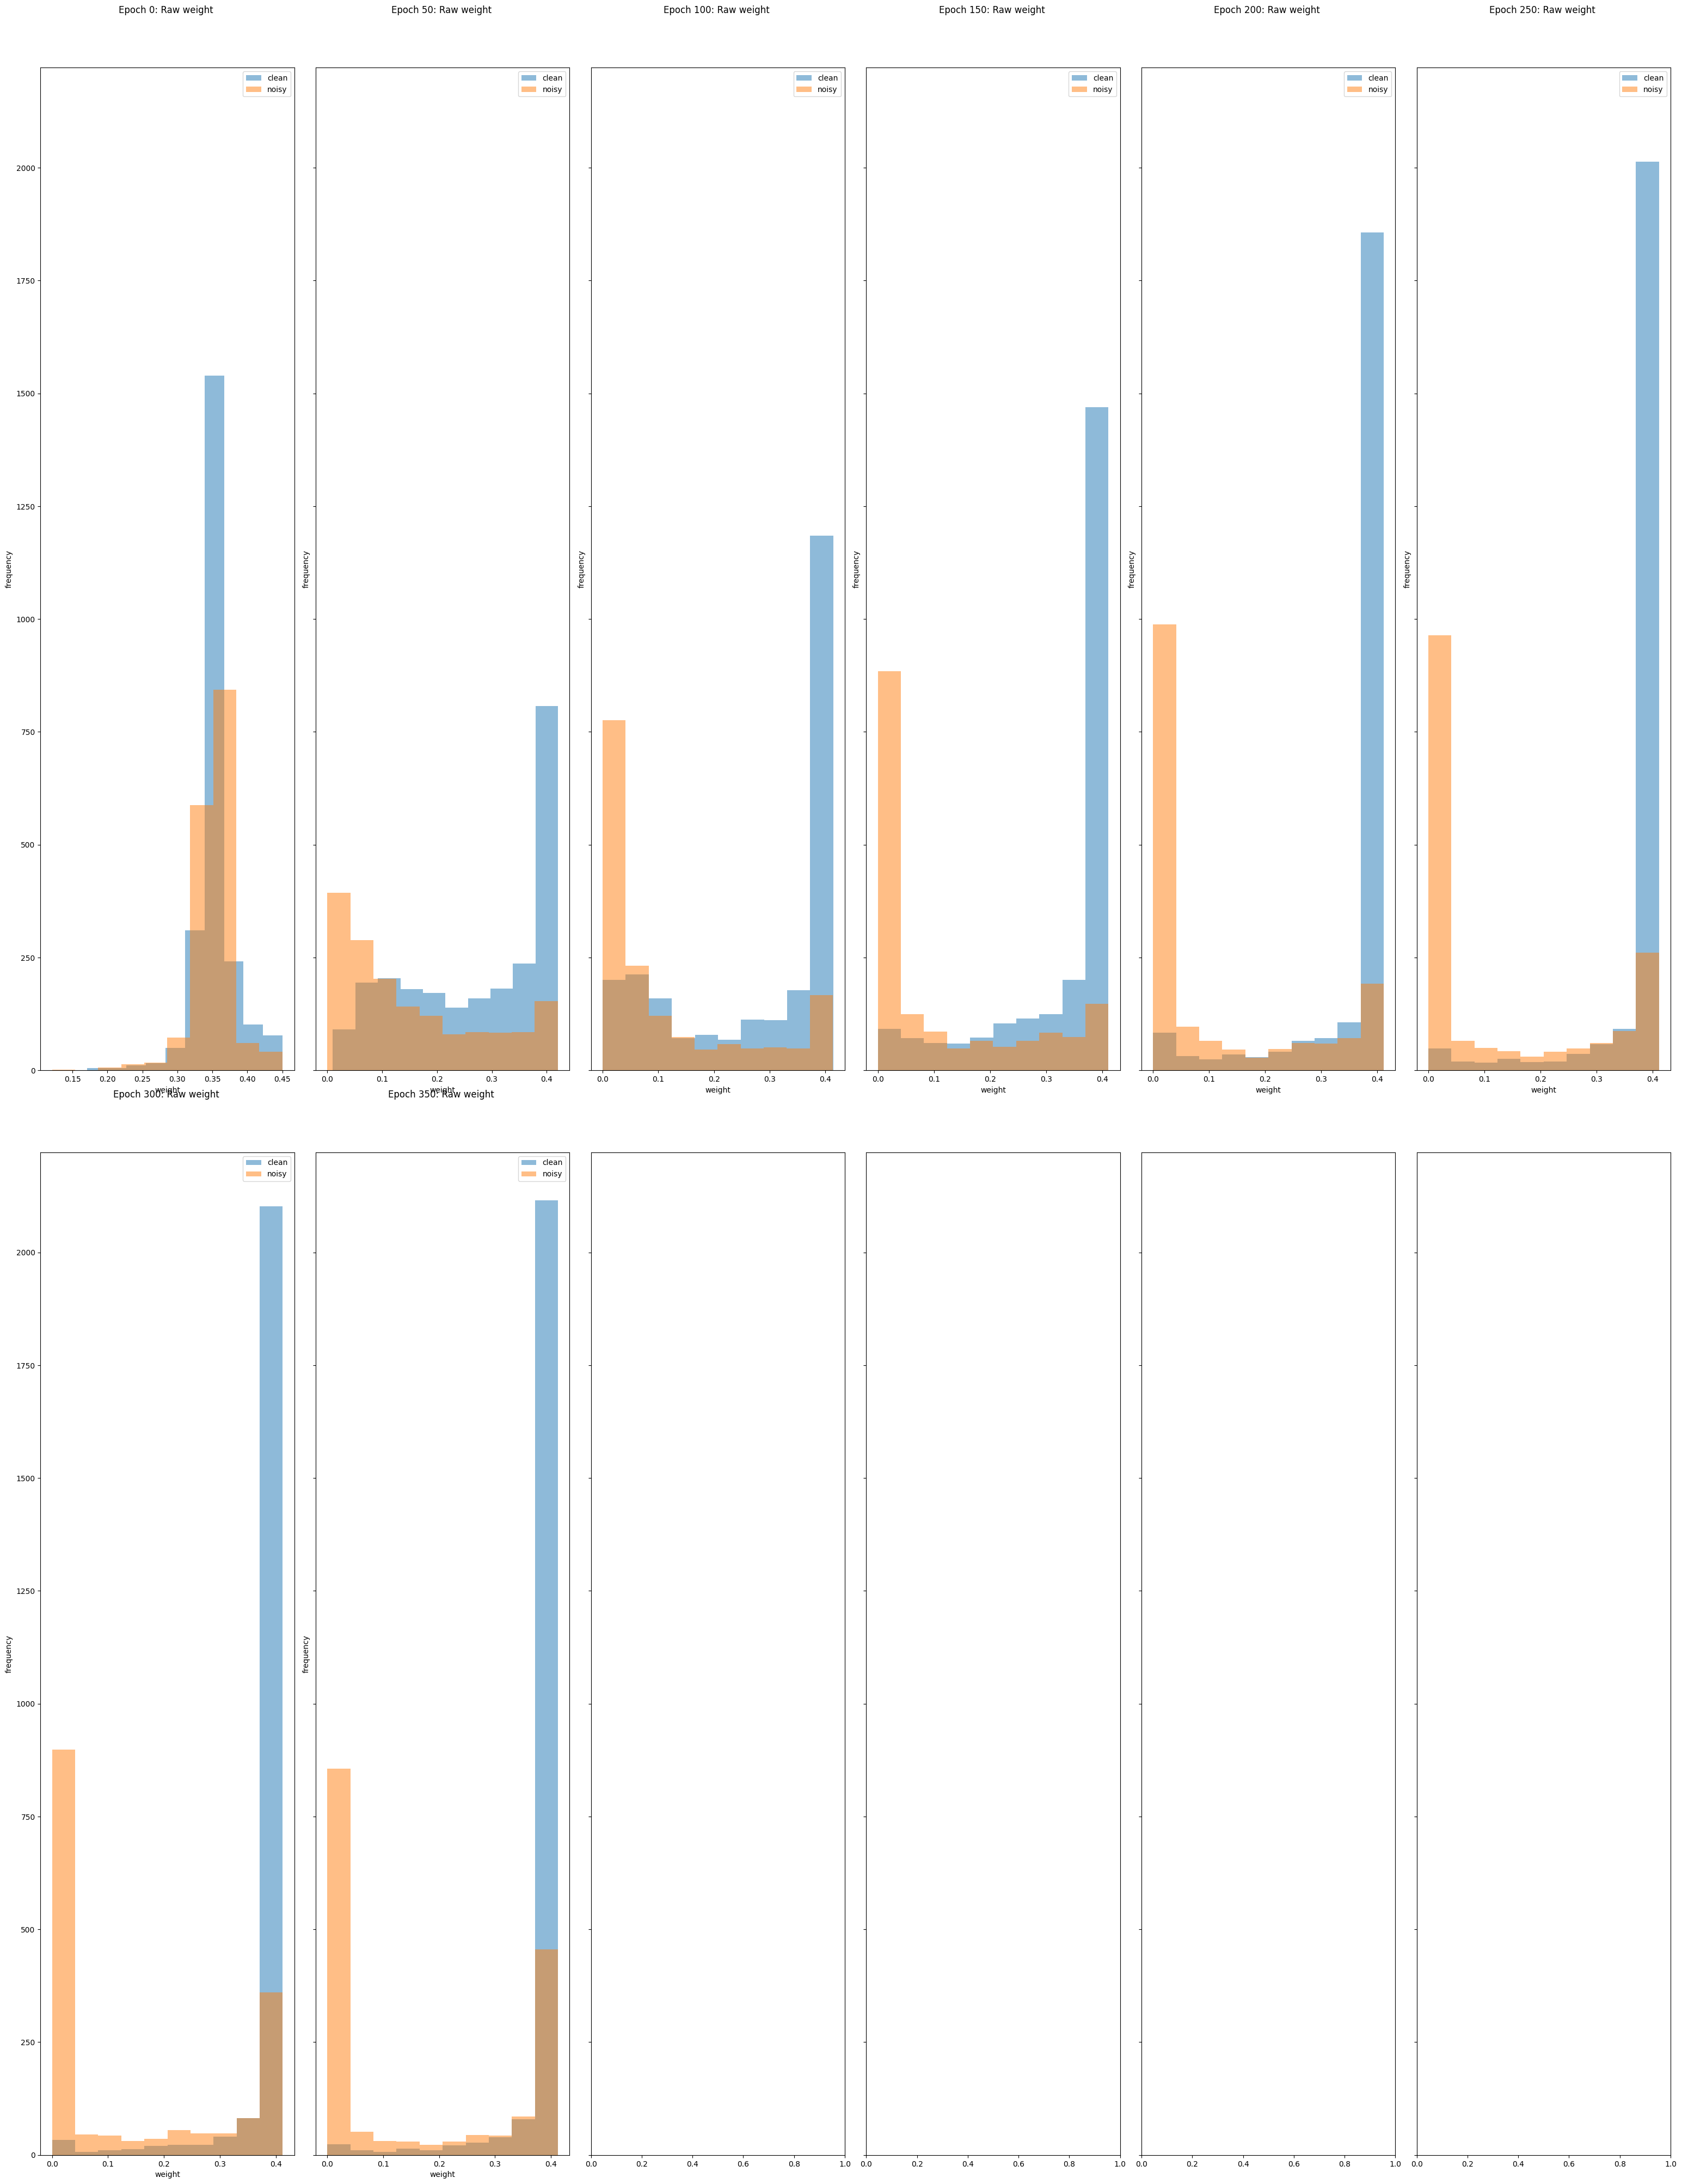

In [22]:
import math
epochs = 400
epoch_weights_=[]
key_name='w_lid_feat_l2'
es=40
t=50
for e in range(epochs):
    e_weights = []
    for i in range(e*es,(e+1)*es):
        
        batch_idx = weight_log['sample_idx'][i]
        to_add_df= df = pd.DataFrame(list(zip( weight_log['labi_lid_feat_l2'][i],weight_log['sample_idx'][i].numpy(), torch.squeeze(weight_log[key_name][i]).numpy(),[1 if idx.item() in weight_log['clean_indices'] else 0 for idx in batch_idx])), 
                                     columns =['train_label','idx','weights','clean_indicator'])    
        # grouped_=to_add_df.groupby(["train_label"]).apply(lambda x: x.sort_values(['weights'], ascending=False)).drop(['train_label'],axis=1)
        
        e_weights.append(to_add_df)
       
    
    epoch_weights_.append(pd.concat(e_weights,axis=0))
epoch_weights =epoch_weights_.copy()
epoch_weights.reverse()
fig, axes = plt.subplots(math.ceil(epochs/(6*t)), 6, tight_layout=True,sharex=False,sharey=True,figsize=(31,40))

i=0
for row in axes:
    for col in row:
        if i*t<len(epoch_weights_):
            # df =epoch_weights.pop()
            df = epoch_weights_[i*t]
            data0 = df['weights'][df['clean_indicator']== 1] # data for clean label
            data1 = df['weights'][df['clean_indicator']== 0] # data for noisy lable    v
            
            # if k==0:
            #     plt.hist(data0)
            # with np.errstate(divide='ignore'):
            col.hist(data0.values, density=False, bins=10, alpha=0.5,label='clean')
            
            col.hist(data1.values,  bins=10, alpha=0.5, label='noisy')

            col.set_xlabel("weight")
            col.set_ylabel("frequency")
            col.set_title(f'Epoch {i*t}: Raw weight ',y=1.05 )
            # col.set_xlim(0,1)
            col.legend(loc='best')
            i+=1
        else:
            break
        
plt.show()

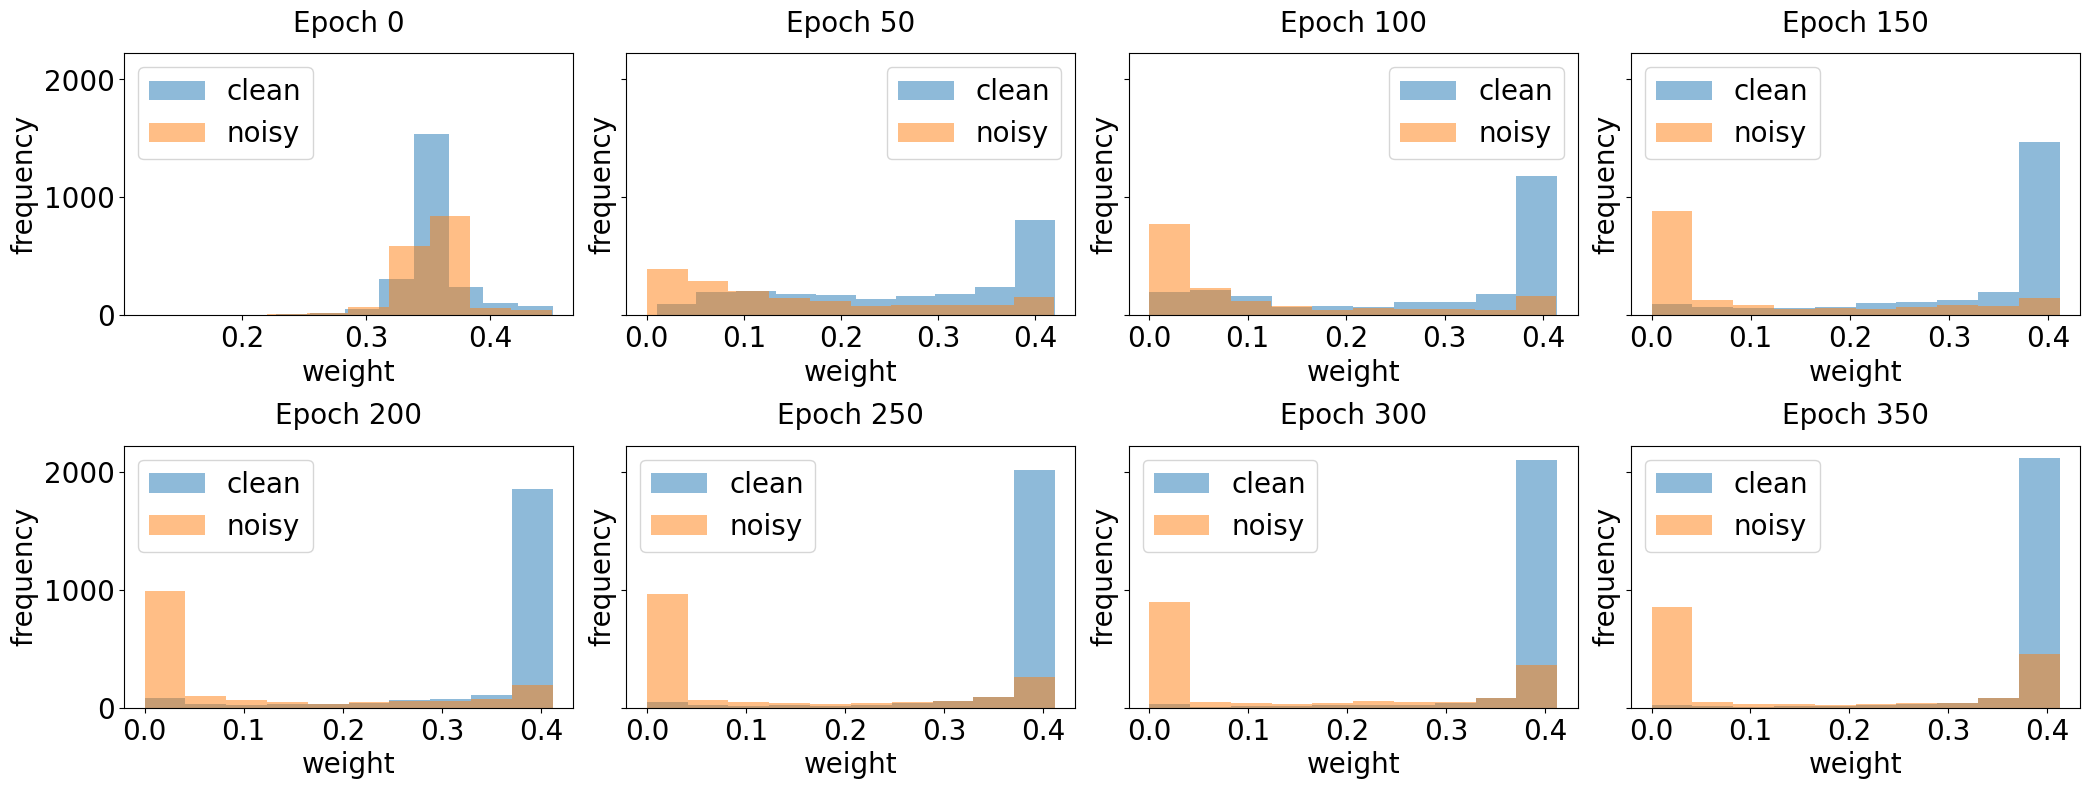

In [23]:
import math
epochs = 400
epoch_weights_=[]
key_name='w_lid_feat_l2'
es=40
t=50
for e in range(epochs):
    e_weights = []
    for i in range(e*es,(e+1)*es):
        
        batch_idx = weight_log['sample_idx'][i]
        to_add_df= df = pd.DataFrame(list(zip( weight_log['labi_lid_feat_l2'][i],weight_log['sample_idx'][i].numpy(), torch.squeeze(weight_log[key_name][i]).numpy(),[1 if idx.item() in weight_log['clean_indices'] else 0 for idx in batch_idx])), 
                                     columns =['train_label','idx','weights','clean_indicator'])    
        # grouped_=to_add_df.groupby(["train_label"]).apply(lambda x: x.sort_values(['weights'], ascending=False)).drop(['train_label'],axis=1)
        
        e_weights.append(to_add_df)
       
    
    epoch_weights_.append(pd.concat(e_weights,axis=0))
epoch_weights =epoch_weights_.copy()
epoch_weights.reverse()
fig, axes = plt.subplots(math.ceil(epochs/(4*t)), 4, tight_layout=True,sharex=False,sharey=True,figsize=(21,8))

i=0
for row in axes:
    for col in row:
        if i*t<len(epoch_weights_):
            # df =epoch_weights.pop()
            df = epoch_weights_[i*t]
            data0 = df['weights'][df['clean_indicator']== 1] # data for clean label
            data1 = df['weights'][df['clean_indicator']== 0] # data for noisy lable    v
            
            # if k==0:
            #     plt.hist(data0)
            # with np.errstate(divide='ignore'):
            col.hist(data0.values, density=False, bins=10, alpha=0.5,label='clean')
            
            col.hist(data1.values,  bins=10, alpha=0.5, label='noisy')
            col.tick_params(axis='x', labelsize=20)
            col.tick_params(axis='y', labelsize=20)
            col.set_xlabel("weight",fontsize=20)
            col.set_ylabel("frequency",fontsize=20)
            col.set_title(f'Epoch {i*t}',y=1.05,fontsize=20)
            # col.set_xlim(0,1)
            col.legend(loc='best',fontsize=20)
            i+=1
        else:
            break
        
plt.show()

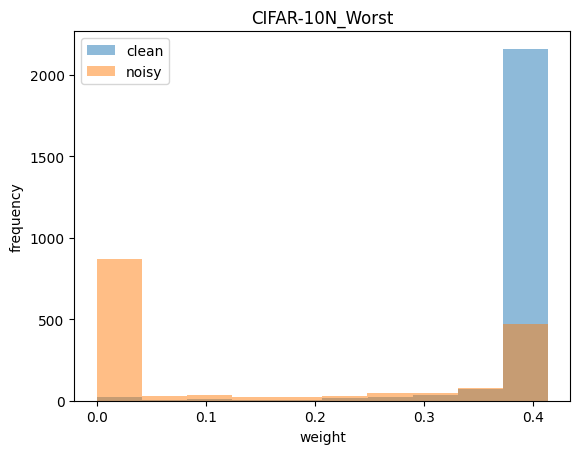

In [24]:
df = epoch_weights_[399]
data0 = df['weights'][df['clean_indicator']== 1] # data for clean label
data1 = df['weights'][df['clean_indicator']== 0] # data for noisy lable    v
plt.hist(data0.values, density=False, bins=10, alpha=0.5,label='clean')

plt.hist(data1.values,  bins=10, alpha=0.5, label='noisy')

plt.xlabel("weight")
plt.ylabel("frequency")
plt.title('CIFAR-10N_Worst')

# col.set_title(f'Epoch {i*t}: Raw weight ',y=1.05 )
# col.set_xlim(0,1)
plt.legend(loc='best')

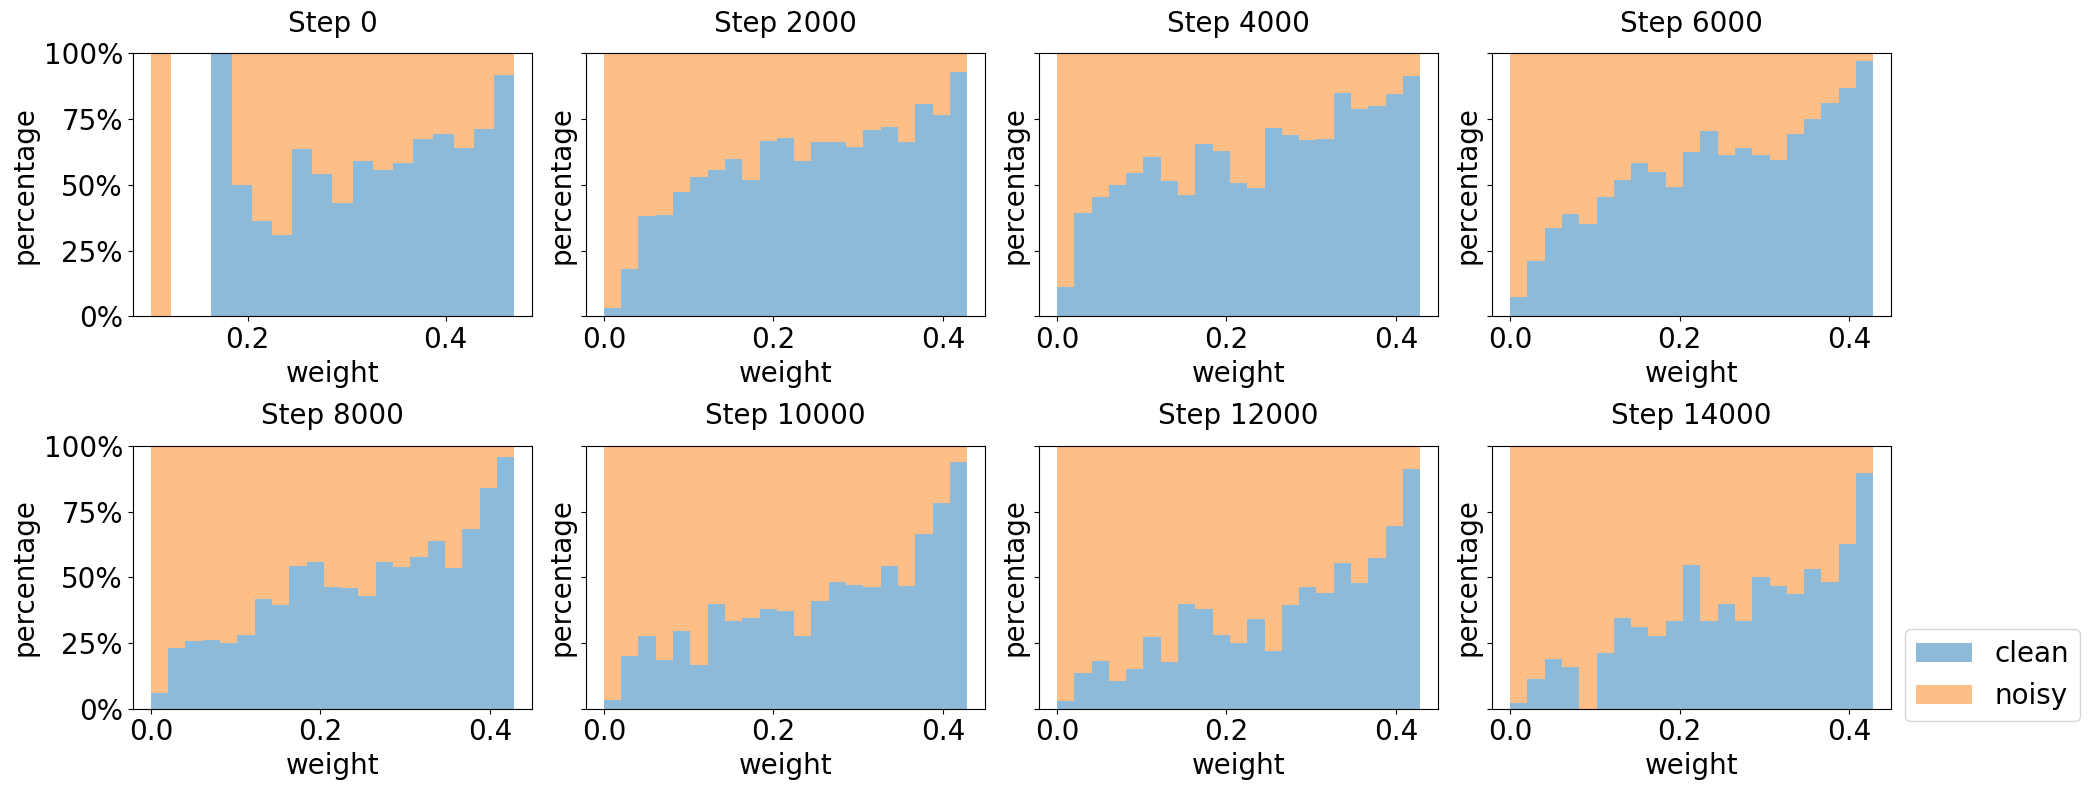

In [25]:
import math
import matplotlib
epochs =400
t=50
epoch_weights_=[]
key_name='w_lid_feat_l2'

for e in range(epochs):
    e_weights = []
    for i in range(e*es,(e+1)*es):
        
        batch_idx = weight_log['sample_idx'][i]
        to_add_df= df = pd.DataFrame(list(zip( weight_log['labi_lid_feat_l2'][i],weight_log['sample_idx'][i].numpy(), torch.squeeze(weight_log[key_name][i]).numpy(),[1 if idx.item() in weight_log['clean_indices'] else 0 for idx in batch_idx])), 
                                     columns =['train_label','idx','weights','clean_indicator'])    
        # grouped_=to_add_df.groupby(["train_label"]).apply(lambda x: x.sort_values(['weights'], ascending=False)).drop(['train_label'],axis=1)
        
        e_weights.append(to_add_df)
       
    
    epoch_weights_.append(pd.concat(e_weights,axis=0))
epoch_weights =epoch_weights_.copy()
epoch_weights.reverse()

fig, axes = plt.subplots(math.ceil(epochs/(4*t)), 4, tight_layout=True,sharex=False,sharey=True,figsize=(21,8))
bins,step = np.linspace(0,1,50, retstep=True)
i=0
for row in axes:
    for col in row:
        
        if i*t<len(epoch_weights_):
            # df =epoch_weights.pop()
            df = epoch_weights_[i*t]
            data0 = df['weights'][df['clean_indicator']== 1] # data for clean label
            data1 = df['weights'][df['clean_indicator']== 0] # data for noisy lable
            hist1,_ = np.histogram(data0.values, bins=bins)
            hist2,_ = np.histogram(data1.values, bins=bins)
            prop1 = 100*hist1/(hist1+hist2)
            prop2 = 100*hist2/(hist1+hist2)
            bar1=col.bar(x=bins[:-1], height=prop1, bottom=0, align='edge', width=step,alpha=0.5,label='clean')
            bar2=col.bar(x=bins[:-1], height=prop2, bottom=prop1, align='edge', width=step,alpha=0.5,label='noisy')
            col.tick_params(axis='x', labelsize=20)
            col.tick_params(axis='y', labelsize=20)
            col.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
            col.set_xlabel("weight",fontsize=20)
            col.set_ylabel("percentage",fontsize=20)
            col.set_title(f'Step {i*t*40}',y=1.05, fontsize=20)
            # col.set_xlim(-0.01,1.01)
            # col.legend(loc='best',fontsize=20)
            i+=1
        else:
            break
bars = [bar1, bar2]
labels = [bar.get_label() for bar in bars]
plt.legend(bars, labels, loc='lower left', bbox_to_anchor=(1, -0.1),fontsize=20)        
# plt.show()
plt.savefig(f'/home/rhu/r_work/higher_semilearn/figures/weight_distribut_clid_random_flex.pdf')


In [ ]:
weight_log['labi_lid_feat_l2'] = []
for idx in weight_log['sample_idx']:
    weight_log['labi_lid_feat_l2'].append(weight_log['train_labels'][idx])

In [ ]:
key_name='w_lid_feat_l2'

es_=es*20
import numpy as np
weights_cllass_dict={k:[] for k in range(10)}
# for i,batch_idx in enumerate(weight_log['sample_idx']):
with np.errstate(invalid='ignore'):
    for i in range(0,30000):
        batch_idx = weight_log['sample_idx'][i]
        to_add_df= df = pd.DataFrame(list(zip(weight_log['labi_lid_feat_l2'][i],weight_log['sample_idx'][i], torch.squeeze(weight_log[key_name][i]).numpy(),[1 if idx.item() in weight_log['clean_indices'] else 0 for idx in batch_idx])), 
                                     columns =['train_label','idx','weights','clean_indicator'])    
        grouped=to_add_df.groupby(["train_label"]).apply(lambda x: x.sort_values(['weights'], ascending=False)).drop(['train_label'],axis=1)

        grouped=grouped.droplevel([1])
        for k in range(10):

            weights_cllass_dict[k].append(grouped[grouped.index==k])

        if i%es_==0 and i>0:
            fig, cols = plt.subplots(1, 10, tight_layout=False,sharex=False,figsize=(31,2.5))
            n_bins=20

            k=0
            for col in cols:
                df=pd.concat(weights_cllass_dict[k],axis=0, ignore_index=True)

                data0 = df['weights'][df['clean_indicator']== 1] # data for clean label
                data1 = df['weights'][df['clean_indicator']== 0] # data for noisy lable    v
                bins,step = np.linspace(0,1,10, retstep=True)
                hist1,_ = np.histogram(data0.values, bins=bins)
                hist2,_ = np.histogram(data1.values, bins=bins)
                prop1 = 100*hist1/(hist1+hist2)
                prop2 = 100*hist2/(hist1+hist2)
                col.bar(x=bins[:-1], height=prop1, bottom=0, align='edge', width=step,alpha=0.5)
                col.bar(x=bins[:-1], height=prop2, bottom=prop1, align='edge', width=step,alpha=0.5)
                col.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
                col.set_xlabel("weight")
                col.set_ylabel("percentage")
                col.set_title(f'Epoch {i}: Raw weight ',y=1.05 )
                # col.set_xlim(-0.01,1.01)
                
                # col.hist([data0.values,data1.values], density=False, bins=10, alpha=0.5, histtype='stepfilled',label=['clean','noisy'])
                # col.hist(data1,  bins=10, alpha=0.5, label='noisy')

                col.set_xlabel("weight")
                col.set_ylabel("percentage")
                col.set_title(f'Class {k}: Raw weight ',y=1.05 )

                # col.legend(loc='best')
                
            
                

                k+=1
                if k== 10:
                    break
            fig.suptitle(f'epoch {i//es}')        
            plt.show()
                

        
            
        if i%es==0:
            weights_cllass_dict={k:[] for k in range(10)}
                

In [ ]:
key_name='w_lid_feat_l2'

es_=es*10
import numpy as np
weights_cllass_dict={k:[] for k in range(10)}
# for i,batch_idx in enumerate(weight_log['sample_idx']):
with np.errstate(invalid='ignore'):
    for i in range(0,20000):
        batch_idx = weight_log['sample_idx'][i]
        to_add_df= df = pd.DataFrame(list(zip( weight_log['labi_lid_feat_l2'][i],weight_log['sample_idx'][i], torch.squeeze(weight_log[key_name][i]).numpy(),[1 if idx.item() in weight_log['clean_indices'] else 0 for idx in batch_idx])), 
                                     columns =['train_label','idx','weights','clean_indicator']) 
        # to_add_df= df = pd.DataFrame(list(zip( weight_log['labi_lid_feat_l2'][i].item(),weight_log['sample_idx'][i].numpy(), weight_log[key_name][i].numpy(),[1 if idx.item() in weight_log['clean_indices'] else 0 for idx in batch_idx])), 
                                     # columns =['train_label','idx','weights','clean_indicator'])    
        grouped=to_add_df.groupby(["train_label"]).apply(lambda x: x.sort_values(['weights'], ascending=False)).drop(['train_label'],axis=1)

        grouped=grouped.droplevel([1])
        for k in range(10):

            weights_cllass_dict[k].append(grouped[grouped.index==k])

        if i%es_==0 and i>0:

            fig, cols = plt.subplots(1, 10, tight_layout=False,sharex=False,figsize=(31,2.5))
            n_bins=20

            k=0
            for col in cols:
                df=pd.concat(weights_cllass_dict[k],axis=0, ignore_index=True)
                # print(df)
                # df = weights_cllass_dict[k]

    
                # get the data for each class
                data0 = df['weights'][df['clean_indicator']== 1] # data for clean label
                data1 = df['weights'][df['clean_indicator']== 0] # data for noisy lable    v
                # if k==0:
                #     plt.hist(data0)
                # with np.errstate(divide='ignore'):
                col.hist([data0.values,data1.values], density=False, bins=10, alpha=0.5, histtype='stepfilled',label=['clean','noisy'])
                # col.hist(data1,  bins=10, alpha=0.5, label='noisy')

                col.set_xlabel("weight")
                col.set_ylabel("density")
                col.set_title(f'Class {k}: Raw weight ',y=1.05 )

                col.legend(loc='best')
                
            
                

                k+=1
                if k== 10:
                    break
            fig.suptitle(f'epoch {i//es}')        
            plt.show()
                

        
            
        if i%es==0:
            weights_cllass_dict={k:[] for k in range(10)}
                

# RMWNET 

In [ ]:
save_dir = "/home/rhu/r_work/higher_semilearn/saved_models/cifar10"
save_name = "b_uda_lossnet_cifar10_wrn_28_2_4000_lr0.03_True_bsz100_human_random_0_False_1000_100_mae_uni_0.001_beta0_2"
save_pth = '/home/rhu/r_work/higher_semilearn/saved_log/cifar10/'+save_name
noise_ratio = 0
d_s=4000
# save_dir = "/home/rhu/r_work/higher_semilearn/saved_models/cifar10_uda"
# save_name = "flag_uda_cifar10_resnet18_1000_lr0.0005_False_bsz128_asy_0.6_True_8960_1280_None_zero_None_10"
# save_pth = '/home/rhu/r_work/higher_semilearn/saved_log/cifar10/'+save_name

# # resume = True
import warnings
warnings.filterwarnings("ignore")

iteration_l =list(range(0,30000,600))
path_dir=os.path.join(save_dir ,save_name)

weight_log_mae = torch.load(os.path.join(path_dir,'data_weight_log.pt'))
weight_log_mae['clean_indices']=np.where(weight_log_mae['true_label'] == weight_log_mae['train_labels'])[0]

In [ ]:
weight_log_mae.keys()

In [ ]:
plt.plot(weight_log_mae['total_meta_loss'])
plt.ylabel('MAE',fontsize=14)
plt.xlabel('Traing step',fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig(f'/home/rhu/r_work/higher_semilearn/figures/mae_loss_flex_random.pdf')


In [111]:
import math
epochs =400
mae_epoch_weights_=[]
key_name='w_lid_feat_l2'
es=40
t=50
for e in range(epochs):
    mae_e_weights = []
    for i in range(e*es,(e+1)*es):
        
        batch_idx = weight_log_mae['sample_idx'][i]
        to_add_df= df = pd.DataFrame(list(zip( weight_log_mae['labi_lid_feat_l2'][i],weight_log_mae['sample_idx'][i].numpy(), \
                                              torch.squeeze(weight_log_mae[key_name][i]).numpy(),[1 if idx.item() in weight_log_mae['clean_indices'] else 0 for idx in batch_idx])), 
                                     columns =['train_label','idx','weights','clean_indicator'])    
        # grouped_=to_add_df.groupby(["train_label"]).apply(lambda x: x.sort_values(['weights'], ascending=False)).drop(['train_label'],axis=1)
        
        mae_e_weights.append(to_add_df)
       
    
    mae_epoch_weights_.append(pd.concat(mae_e_weights,axis=0))
mae_epoch_weights = mae_epoch_weights_.copy()
mae_epoch_weights.reverse()

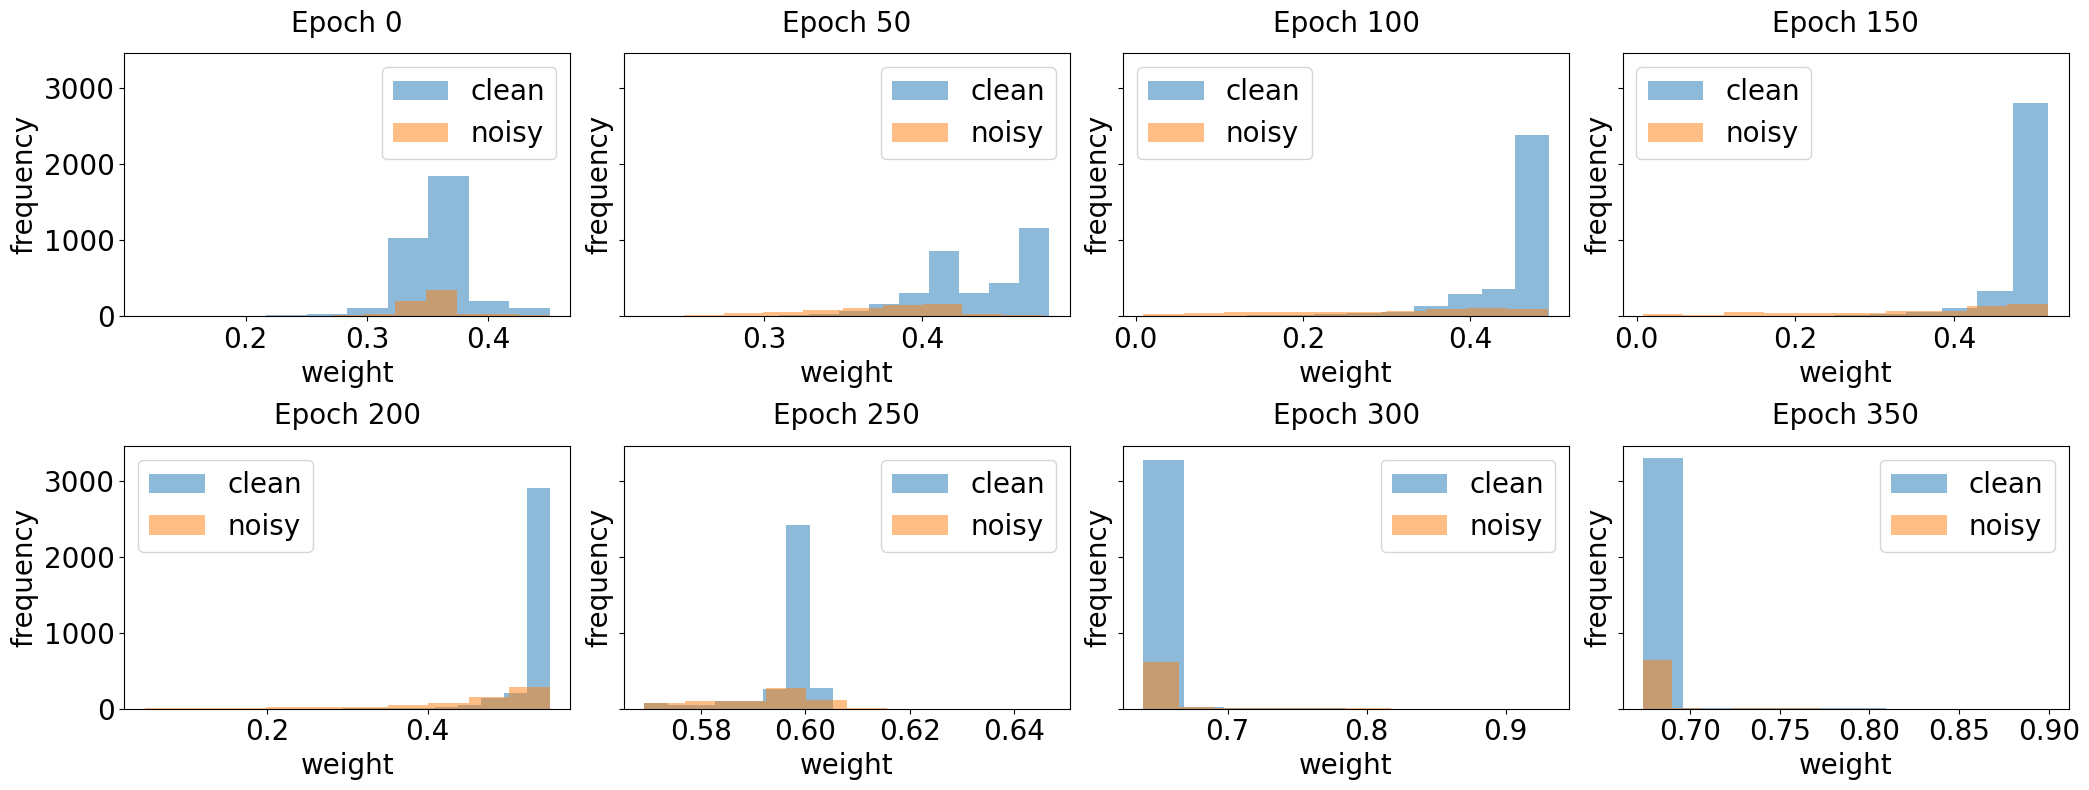

In [147]:

fig, axes = plt.subplots(math.ceil(epochs/(4*t)), 4, tight_layout=False,sharex=False,sharey=True,figsize=(21,8))

i=0
for row in axes:
    
    for col in row:
        if i*t<len(mae_epoch_weights_):
            # df =epoch_weights.pop()
            df_mae = mae_epoch_weights_[i*t]
            data0_mae = df_mae['weights'][df_mae['clean_indicator']== 1] # data for clean label
            data1_mae = df_mae['weights'][df_mae['clean_indicator']== 0] # data for noisy lable    v            
            # if k==0:
            #     plt.hist(data0)
            # with np.errstate(divide='ignore'):
            col.hist(data0_mae.values, density=False, bins=10, alpha=0.5,label='clean')
            
            col.hist(data1_mae.values,  bins=10, alpha=0.5, label='noisy')
            col.tick_params(axis='x', labelsize=20)
            col.tick_params(axis='y', labelsize=20)

            col.set_xlabel("weight",fontsize=20)
            col.set_ylabel("frequency",fontsize=20)
            col.set_title(f'Epoch {i*t}',y=1.05,fontsize=20)
            # col.set_xlim(0,1)
            col.legend(loc='best',fontsize=20)
            i+=1
        else:
            break
        
# plt.show()
plt.savefig(f'/home/rhu/r_work/higher_semilearn/figures/weight_distribut_mae_random_flex.pdf')


In [ ]:
df_mae = mae_epoch_weights_[190]
data0_mae = df_mae['weights'][df_mae['clean_indicator']== 1] # data for clean label
data1_mae = df_mae['weights'][df_mae['clean_indicator']== 0] # data for noisy lable    v
plt.figure(figsize=(5, 3))  # Adjust the figure size (width, height)
plt.hist(data0_mae.values, density=False, bins=100, alpha=0.5,label='clean')

plt.hist(data1_mae.values,  bins=100, alpha=0.5, label='noisy')

plt.xlabel("Weight")
# plt.ylabel("frequency")
plt.title('MAE: CIFAR-10N_Worst')
plt.ylim(0,1400)
# col.set_title(f'Epoch {i*t}: Raw weight ',y=1.05 )
# plt.xlim(-0.1,0.35)
plt.legend(loc='best')
# plt.savefig('/home/rhu/r_work/higher_semilearn/figures/mae_cifar10_worst.pdf')

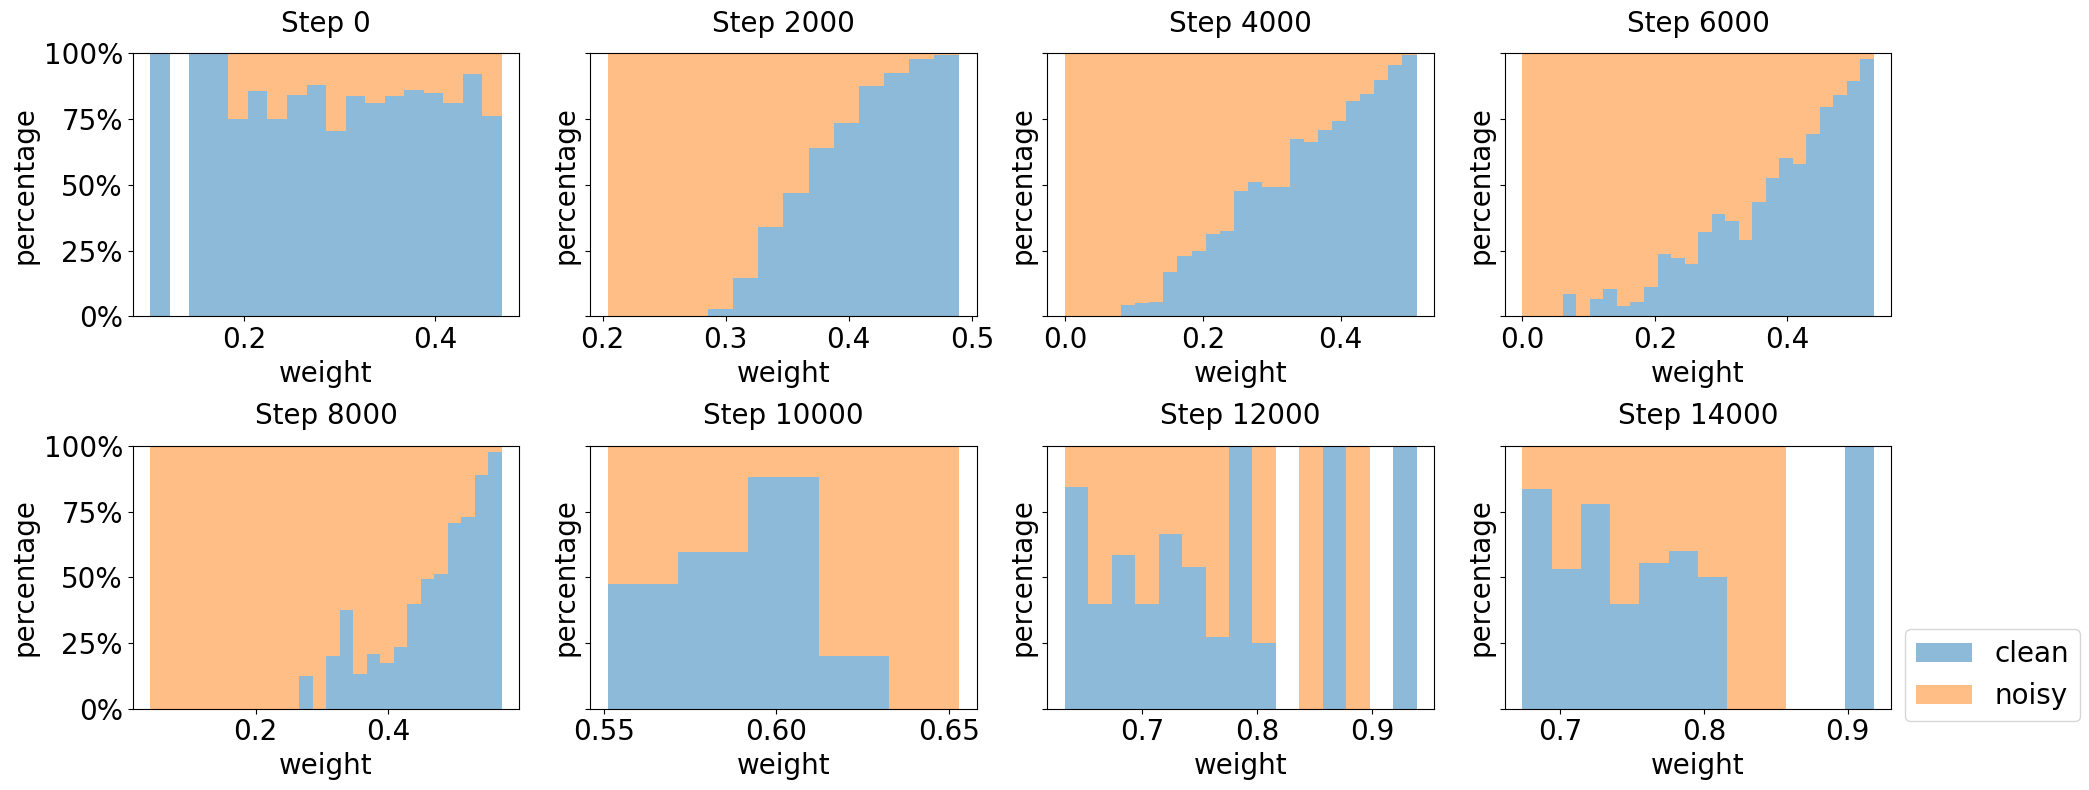

In [167]:


fig, axes = plt.subplots(math.ceil(epochs/(4*t)), 4, tight_layout=True,sharex=False,sharey=True,figsize=(21,8))
bins,step = np.linspace(0,1,50, retstep=True)
i=0
for row in axes:
    for col in row:
        
        if i*t<len(mae_epoch_weights_):
            # df =epoch_weights.pop()
            df_mae = mae_epoch_weights_[i*t]
            data0 = df_mae['weights'][df_mae['clean_indicator']== 1] # data for clean label
            data1 = df_mae['weights'][df_mae['clean_indicator']== 0] # data for noisy lable
            hist1,_ = np.histogram(data0.values, bins=bins)
            hist2,_ = np.histogram(data1.values, bins=bins)
            prop1 = 100*hist1/(hist1+hist2)
            prop2 = 100*hist2/(hist1+hist2)
            col.bar(x=bins[:-1], height=prop1, bottom=0, align='edge', width=step,alpha=0.5,label='clean')
            col.bar(x=bins[:-1], height=prop2, bottom=prop1, align='edge', width=step,alpha=0.5,label='noisy')
            col.tick_params(axis='x', labelsize=20)
            col.tick_params(axis='y', labelsize=20)
            col.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
            col.set_xlabel("weight",fontsize=20)
            col.set_ylabel("percentage",fontsize=20)
            col.set_title(f'Step {i*t*40}',y=1.05, fontsize=20)
            # col.set_xlim(-0.01,1.01)
            # col.legend(loc='best',fontsize=20)
            i+=1
        else:
            break
bars = [bar1, bar2]
labels = [bar.get_label() for bar in bars]
plt.legend(bars, labels, loc='lower left', bbox_to_anchor=(1, -0.1),fontsize=20)  
plt.legend(bars, labels, loc='lower left', bbox_to_anchor=(1, -0.1),fontsize=20)        
        
# plt.show()
plt.savefig(f'/home/rhu/r_work/higher_semilearn/figures/weight_distribut_mae_random.pdf')


In [ ]:
fig, axes = plt.subplots(math.ceil(epochs/(6*t)), 6, tight_layout=True,sharex=False,sharey=True,figsize=(31,40))

i=0
for row in axes:
    for col in row:
        if i*t<len(mae_epoch_weights):
            # df =epoch_weights.pop()
            df_mae = mae_epoch_weights[i*t]
            data0_mae = df_mae['weights'][df_mae['clean_indicator']== 1] # data for clean label
            data1_mae = df_mae['weights'][df_mae['clean_indicator']== 0] # data for noisy lable    v
            
            # if k==0:
            #     plt.hist(data0)
            # with np.errstate(divide='ignore'):
            col.hist(data0_mae.values, density=False, bins=30, alpha=0.5,label='clean')
            
            col.hist(data1_mae.values,  bins=30, alpha=0.5, label='noisy')

            col.set_xlabel("weight")
            col.set_ylabel("frequency")
            col.set_title(f'Epoch {i*t}: Raw weight ',y=1.05 )
            # col.set_xlim(0,1)
            col.legend(loc='best')
            i+=1
        else:
            break
        
plt.show()

In [ ]:
df = epoch_weights_[190]
base=df['weights'].max()-df['weights'].min()
data0 = df['weights'][df['clean_indicator']== 1] # data for clean label
data1 = df['weights'][df['clean_indicator']== 0] # data for noisy lable    v
plt.figure(figsize=(5, 3))  # Adjust the figure size (width, height)
plt.hist(data0.values, density=False, bins=100, alpha=0.5,label='clean')

plt.hist(data1.values,  bins=100, alpha=0.5, label='noisy')

plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.title('CLID: CIFAR-10N_Worst')
plt.ylim(0,1400)
# col.set_title(f'Epoch {i*t}: Raw weight ',y=1.05 )
# plt.xlim(-0.01,0.45)
plt.legend(loc='best')
# plt.savefig('/home/rhu/r_work/higher_semilearn/figures/clid_cifar10_worst.pdf')

In [ ]:
# Create a figure and two subplots
epochi = 120
df_mae = mae_epoch_weights_[epochi]
data0_mae = df_mae['weights'][df_mae['clean_indicator']== 1] # data for clean label
data1_mae = df_mae['weights'][df_mae['clean_indicator']== 0] # data for noisy lable    v

df = epoch_weights_[315]
base=df['weights'].max()-df['weights'].min()
data0 = df['weights'][df['clean_indicator']== 1] # data for clean label
data1 = df['weights'][df['clean_indicator']== 0] # data for noisy lable    v
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 2),sharey=True)

# Plot on the first subplot
bar1=ax1.hist(data0.values, density=False, bins=10, alpha=0.5,label='clean')
bar2=ax1.hist(data1.values,  bins=10, alpha=0.5, label='noisy')
ax1.set_title('CLID: CIFAR-10N_Worst')
ax1.set_xlabel("Weight",fontsize=14)
ax1.set_ylabel('Frequency',fontsize=14)
ax1.legend()
# ax1.set_ylim(0,1400)
ax1.grid(True,color='#d3d3d3')
ax1.tick_params(axis='x', labelsize=12)  # Set x-axis tick label font size
ax1.tick_params(axis='y', labelsize=12)  # Set x-axis tick label font size

# Plot on the second subplot
ax2.hist(data0_mae.values, density=False, bins=10, alpha=0.5,label='clean')

ax2.hist(data1_mae.values,  bins=10, alpha=0.5, label='noisy')

ax2.set_xlabel("Weight",fontsize=14)
# plt.ylabel("frequency")
ax2.set_title('MAE: CIFAR-10N_Worst')

ax2.legend()
ax2.grid(True,color='#d3d3d2')
ax2.tick_params(axis='x', labelsize=12)  # Set x-axis tick label font size

# Adjust layout
plt.tight_layout()

# Show the plot
# plt.show()
# plt.savefig('/home/rhu/r_work/higher_semilearn/figures/combined_cifar10_worst.pdf')

In [ ]:
bins,step = np.linspace(0,df['weights'].max(),50, retstep=True)

hist1,_ = np.histogram(data0.values, bins=bins)
hist2,_ = np.histogram(data1.values, bins=bins)
prop1 = 100*hist1/(hist1+hist2)
prop2 = 100*hist2/(hist1+hist2)
plt.bar(x=bins[:-1], height=prop1, bottom=0, align='edge', width=step,alpha=0.5,label='clean')
plt.bar(x=bins[:-1], height=prop2, bottom=prop1, align='edge', width=step,alpha=0.5,label='noisy')
# plt.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
plt.xlabel("weight")
plt.ylabel("percentage")
plt.title('CLID: CIFAR-10N_Worst')
# col.set_xlim(-0.01,1.01)
plt.legend(loc='best')

In [ ]:
bins,step = np.linspace(0,df_mae['weights'].max(),50, retstep=True)

hist1_mae,_ = np.histogram(data0_mae.values, bins=bins)
hist2_mae,_ = np.histogram(data1_mae.values, bins=bins)
prop1_mae = 100*hist1_mae/(hist1_mae+hist2_mae)
prop2_mae = 100*hist2_mae/(hist1_mae+hist2_mae)
plt.bar(x=bins[:-1], height=prop1_mae, bottom=0, align='edge', width=step,alpha=0.5,label='clean')
plt.bar(x=bins[:-1], height=prop2_mae, bottom=prop1_mae, align='edge', width=step,alpha=0.5,label='noisy')
# plt.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
plt.xlabel("weight")
plt.ylabel("percentage")
plt.title('MAE: CIFAR-10N_Worst')
# col.set_xlim(-0.01,1.01)
plt.legend(loc='upper left')

In [ ]:
bins,step = np.linspace(0,df_mae['weights'].max(),0, retstep=True)

hist1_mae,_ = np.histogram(data0_mae.values, bins=bins)
hist2_mae,_ = np.histogram(data1_mae.values, bins=bins)
prop1_mae = 100*hist1_mae/(hist1_mae+hist2_mae)
prop2_mae = 100*hist2_mae/(hist1_mae+hist2_mae)
plt.bar(x=bins[:-1], height=prop1_mae, bottom=0, align='edge', width=step,alpha=0.5,label='clean')
plt.bar(x=bins[:-1], height=prop2_mae, bottom=prop1_mae, align='edge', width=step,alpha=0.5,label='noisy')
# plt.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
plt.xlabel("weight")
plt.ylabel("percentage")
plt.title('MAE: CIFAR-10N_Worst')
# col.set_xlim(-0.01,1.01)
plt.legend(loc='upper left')

# Convergence

In [ ]:
plt.plot(log_['train/sup_loss_weighted']['value'], label='Training Loss') #which is the training loss

ids=log_['train/sup_loss_weighted']['step'].values


# ax3.plot(log_['eval/loss']['step'],log_['eval/loss']['value'][:steps],label='test/loss')
# ax3.set_xlabel("Iteration")
# ax3.set_ylabel("Loss")
# ax3.legend()
# ax3.set_title('Test Set - Loss')

# ax4.plot(log_['eval/top-1-acc']['step'],log_['eval/top-1-acc']['value'][:steps] ,label='test/top-1-acc')
# ax4.set_xlabel("Iteration")
# ax4.set_ylabel("Acc")
# ax4.legend()
# ax4.set_title('Test Set - Acc')

# ax6.plot(log_['train_val_acc']['step'][:steps],log_['train_val_acc']['value'][:steps],label='val/top-1-acc')
# ax6.set_xlabel("Iteration")
# ax6.set_ylabel("Validation Acc")
# ax6.legend()
# ax6.set_title('Validation Set - Acc')

plt.plot(np.array(weight_log['unl_ce_loss'])[ids],label='CE loss')

plt.plot(np.array(weight_log['total_meta_loss'])[ids],label='Meta loss')
plt.xlabel("Training step")
plt.legend()
# plt.set_title('meta_loss')

In [ ]:
import torch
print(torch.__version__)


In [ ]:
fig, ax1 = plt.subplots()

# Plot the first metric
ax1.set_xlabel('Training Step')
ax1.set_ylabel('CLID')
ids=log_['train/sup_loss_weighted']['step'].values

line1, = ax1.plot(log_['train/sup_loss_weighted']['step'],np.array(weight_log['total_meta_loss'])[ids], color='tab:blue', label='Meta loss (CLID)')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Cross entropy')
line2, = ax2.plot(log_['train/sup_loss_weighted']['step'],log_['train/sup_loss_weighted']['value'],color='tab:orange',label='Training loss (CE)')
# line3, = ax2.plot(log_['train/sup_loss_weighted']['step'],np.array(weight_log['unl_ce_loss'])[ids],color='tab:green',label='Meta clean loss (CE)')

ax2.tick_params(axis='y')


lines = [line1, line2]
labels = [line.get_label() for line in lines]
# ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.1, 1))
ax1.legend(lines, labels, loc='upper right')

# Adjust layout to make room for the legend
# plt.tight_layout(rect=[0, 0, 0.75, 1])
# plt.show()
plt.savefig('/home/rhu/r_work/higher_semilearn/figures/clid_cifar10_worst_convergence.pdf')

In [ ]:
def k_format(x, pos):
    if x >= 1000:
        return f'{int(x/1000)}k'
    else:
        return f'{int(x)}'
import matplotlib.ticker as ticker

In [ ]:
save_dir = "/home/rhu/r_work/higher_semilearn/saved_models/cifar10"
# save_name = "b_0.1_flexmatch_lossnet_cifar10_wrn_28_2_4000_lr0.03_True_bsz100_human_worst_0_False_1000_1000_feat_expno1N_uni_1e-05_beta0_2"
save_name = "b_0.1_flexmatch_lossnet_cifar10_wrn_28_2_4000_lr0.03_True_bsz100_human_worst_0_False_1000_100_feat_expno1N_uni_1e-05_beta0_8"


path_dir=os.path.join(save_dir ,save_name)

weight_log = torch.load(os.path.join(path_dir,'data_weight_log.pt'))
event_name = os.listdir(os.path.join(path_dir,'tensorboard'))[-1]

path_event = os.path.join(path_dir,'tensorboard', event_name)

log_ = parse_tensorboard(path_event, scalars)
fig, ax1 = plt.subplots(figsize=(8, 6))
ids=log_['train/sup_loss_weighted']['step'].values
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(k_format))

# Plot the first metric
ax1.set_xlabel('Training Step',fontsize=16)
ax1.set_ylabel('CLID',fontsize=16)
line1, = ax1.plot(log_['train/sup_loss_weighted']['step'],np.array(weight_log['total_meta_loss'])[ids], color='tab:blue', label='Meta loss (CLID)')
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Cross entropy',fontsize=19)
line2, = ax2.plot(log_['train/sup_loss_weighted']['step'],log_['train/sup_loss_weighted']['value'],color='tab:orange',label='Training loss (CE)')
# line3, = ax2.plot(log_['eval/loss']['step'],log_['eval/loss']['value'],color='tab:green',label='Meta clean loss (CE)')

ax2.tick_params(axis='y')


lines = [line1, line2]
labels = [line.get_label() for line in lines]
# ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.1, 1))
ax1.legend(lines, labels, loc='upper right',fontsize=20)
ax1.tick_params(axis='x', labelsize=16)  # Set x-axis tick label font size
ax1.tick_params(axis='y', labelsize=16)  # Set x-axis tick label font size
ax2.tick_params(axis='y', labelsize=16)  # Set x-axis tick label font size

# Adjust layout to make room for the legend
# plt.tight_layout(rect=[0, 0, 0.75, 1])
# plt.show()
# plt.savefig('/home/rhu/r_work/higher_semilearn/figures/clid_cifar10_worst_convergence.pdf')